In [13]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
#!pip uninstall tensorflow

In [ ]:
#!pip install tensorflow==2.5.0

In [ ]:
!pip list | grep tensorflow

tensorflow                    2.5.0              
tensorflow-datasets           4.0.1              
tensorflow-estimator          2.5.0              
tensorflow-gcs-config         2.5.0              
tensorflow-hub                0.12.0             
tensorflow-metadata           1.0.0              
tensorflow-probability        0.12.1             


In [14]:
import sys
sys.path.insert(0,'/content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/unet_architecture')
sys.path.insert(0,'/content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data')
from unet import unet
from helpers import display, load_data, plot_train_hist, calculateClassIOU


In [15]:
import os, glob
import matplotlib.pyplot as plt
import numpy as np
import pickle
import nibabel as nb
import matplotlib.image as mpimg
import cv2
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.utils import normalize
from tensorflow.keras.utils import to_categorical
from tqdm.notebook import tqdm
from sys import getsizeof
from tensorflow.keras.models import load_model
from datetime import datetime

import nibabel as nib

In [4]:
model

NameError: ignored

In [ ]:
tf.keras.backend.clear_session()
del model

In [ ]:
512/3

170.66666666666666

In [6]:
# Define constants

# Path variables
data_dir = '/content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/'
data_dir_train_image = os.path.join(data_dir, 'data_splits_preprocessed/training/img:-1000:1000/img/')
data_dir_train_mask = os.path.join(data_dir,  'data_splits_preprocessed/training/couinaud/img/')

data_dir_test_image = os.path.join(data_dir, 'data_splits_preprocessed/testing/img:-1000:1000/img/')
data_dir_test_mask = os.path.join(data_dir, 'data_splits_preprocessed/testing/couinaud/img/')

data_dir_validate_image = os.path.join(data_dir, 'data_splits_preprocessed/validate/img:-1000:1000/img/')
data_dir_validate_mask = os.path.join(data_dir, 'data_splits_preprocessed/validate/couinaud/img/')

class_names = ['class_0','class_1','class_2','class_3',
               'class_4','class_5','class_6','class_7','class_8']

# Training variables
SEED = 7
BATCH_SIZE_TRAIN = 10
BATCH_SIZE_TEST = 10
BATCH_SIZE_VALIDATE = 10
NUM_TRAIN = 9288
NUM_TEST = 1042
NUM_VALIDATE = 1207

N_CLASSES = 9
BATCH_SIZE_LIST = [12,16,32,64,128]


# Image variables
IMAGE_HEIGHT = int(192)
IMAGE_WIDTH = int(192)
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)


#Original Image size
OG_IMAGE_HEIGHT = 512
OG_IMAGE_WIDTH = 512
OG_IMG_SIZE = (OG_IMAGE_HEIGHT, OG_IMAGE_WIDTH)

NUM_EPOCH = 100

#Load Data 

In [7]:
#Load data
scaled_train_images    = load_data(data_dir_train_image, isPNG=True, resize=True, NEW_IMG_SIZE=IMG_SIZE)
scaled_train_masks     = load_data(data_dir_train_mask, isPNG=False, resize=True, NEW_IMG_SIZE=IMG_SIZE)

scaled_validate_images = load_data(data_dir_validate_image, isPNG=True, resize=True, NEW_IMG_SIZE=IMG_SIZE)
scaled_validate_masks  = load_data(data_dir_validate_mask, isPNG=False, resize=True, NEW_IMG_SIZE=IMG_SIZE)


Dimmensions:  (9288, 192, 192)
Data Type  :  <class 'numpy.uint8'>
Size in MB :  326.53





Dimmensions:  (9288, 192, 192)
Data Type  :  <class 'numpy.uint8'>
Size in MB :  326.53





Dimmensions:  (1207, 192, 192)
Data Type  :  <class 'numpy.uint8'>
Size in MB :  42.43





Dimmensions:  (1207, 192, 192)
Data Type  :  <class 'numpy.uint8'>
Size in MB :  42.43




In [8]:
#Shuffle the training data
from sklearn.utils import shuffle
scaled_train_images, scaled_train_masks = shuffle(scaled_train_images,scaled_train_masks, random_state = SEED)

In [9]:
#Expand dimensions (print size and type for sanity check)

scaled_train_images = np.expand_dims(scaled_train_images, axis=3).astype('float32')
scaled_validate_images = np.expand_dims(scaled_validate_images, axis=3).astype('float32')

print('#### IMAGES ###')
print(scaled_train_images.shape)
print(type(scaled_train_images[0,0,0,0]))

print(scaled_validate_images.shape)
print(type(scaled_validate_images[0,0,0,0]))

##########################################################################
scaled_train_masks = np.expand_dims(scaled_train_masks, axis=3).astype('float32')
scaled_validate_masks = np.expand_dims(scaled_validate_masks, axis=3).astype('float32')

print('#### MASKS ###')
print(scaled_train_masks.shape)
print(type(scaled_train_masks[0,0,0,0]))

print(scaled_validate_masks.shape)
print(type(scaled_validate_masks[0,0,0,0]))

#### IMAGES ###
(9288, 192, 192, 1)
<class 'numpy.float32'>
(1207, 192, 192, 1)
<class 'numpy.float32'>
#### MASKS ###
(9288, 192, 192, 1)
<class 'numpy.float32'>
(1207, 192, 192, 1)
<class 'numpy.float32'>


#Encode Masks

In [10]:
#Encode labels for all masks
scaled_train_masks = to_categorical(scaled_train_masks, num_classes=N_CLASSES)

print(scaled_train_masks.shape)
print(type(scaled_train_masks[0,0,0,0]))
round(getsizeof(scaled_train_masks) / 1024 / 1024 / 1024 ,2) #GB 

(9288, 192, 192, 9)
<class 'numpy.float32'>


0.0

In [11]:
scaled_validate_masks = to_categorical(scaled_validate_masks, num_classes=N_CLASSES)


print(scaled_validate_masks.shape)
print(type(scaled_validate_masks[0,0,0,0]))
round(getsizeof(scaled_validate_masks) / 1024 / 1024 / 1024 ,2) #GB 

(1207, 192, 192, 9)
<class 'numpy.float32'>


0.0

#Train Multiple Models

Epoch 1/100
774/774 [==============================] - 81s 83ms/step - loss: 0.1876 - mean_io_u: 0.7670 - val_loss: 0.0976 - val_mean_io_u: 0.7630
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0527_03:03/assets
Epoch 2/100
774/774 [==============================] - 64s 83ms/step - loss: 0.0681 - mean_io_u: 0.8163 - val_loss: 0.0611 - val_mean_io_u: 0.8354
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0527_03:03/assets
Epoch 3/100
774/774 [==============================] - 64s 83ms/step - loss: 0.0474 - mean_io_u: 0.8120 - val_loss: 0.0466 - val_mean_io_u: 0.8086
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0527_03:03/assets
Epoch 4/100
774/774 [==============================] - 64s 83ms/step - loss: 0.038

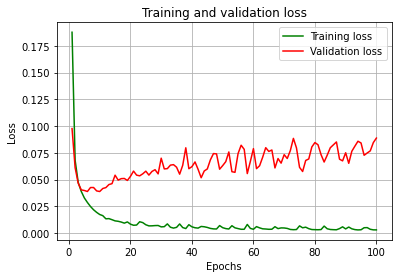

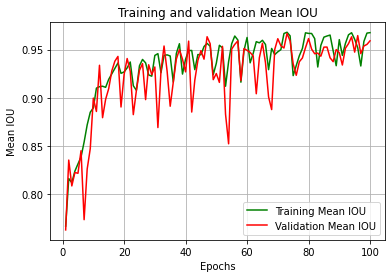

Epoch 1/100
580/580 [==============================] - 65s 108ms/step - loss: 0.2288 - mean_io_u: 0.7724 - val_loss: 0.1256 - val_mean_io_u: 0.8091
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0527_04:51/assets
Epoch 2/100
580/580 [==============================] - 63s 107ms/step - loss: 0.0997 - mean_io_u: 0.8045 - val_loss: 0.0707 - val_mean_io_u: 0.8350
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0527_04:51/assets
Epoch 3/100
580/580 [==============================] - 62s 107ms/step - loss: 0.0670 - mean_io_u: 0.8119 - val_loss: 0.0590 - val_mean_io_u: 0.8296
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0527_04:51/assets
Epoch 4/100
580/580 [==============================] - 62s 107ms/step - loss: 0

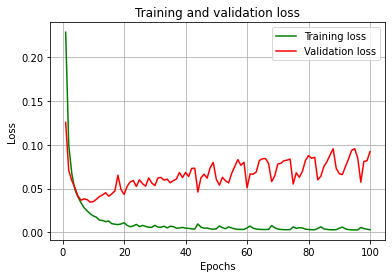

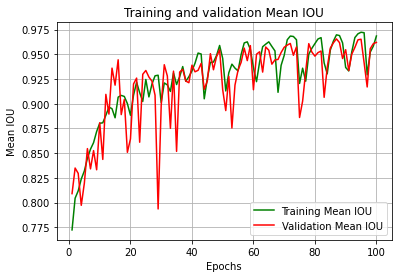

Epoch 1/100
290/290 [==============================] - 64s 210ms/step - loss: 0.2236 - mean_io_u: 0.7742 - val_loss: 0.1396 - val_mean_io_u: 0.7781
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0527_06:35/assets
Epoch 2/100
290/290 [==============================] - 60s 209ms/step - loss: 0.0990 - mean_io_u: 0.8116 - val_loss: 0.0746 - val_mean_io_u: 0.8254
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0527_06:35/assets
Epoch 3/100
290/290 [==============================] - 60s 208ms/step - loss: 0.0728 - mean_io_u: 0.8269 - val_loss: 0.0598 - val_mean_io_u: 0.8317
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0527_06:35/assets
Epoch 4/100
290/290 [==============================] - 60s 208ms/step - loss: 0

KeyboardInterrupt: ignored

In [ ]:
for size in BATCH_SIZE_LIST:
  BATCH_SIZE_TRAIN = size
  BATCH_SIZE_VALIDATE = size 

  #Get time for modelname
  all_names = []
  now = datetime.now()
  dt_string = now.strftime("%m%d_%H:%M")
  all_names.append(dt_string)

  #Check point and output path 
  checkpoint_filepath = '/content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/' + dt_string + '/'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=False,
      monitor='val_loss',
      mode='auto',
      save_best_only=True)

  # Batches per epoch
  EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
  EPOCH_STEP_VALIDATE = NUM_VALIDATE // BATCH_SIZE_VALIDATE

  #Create/Compile Model 
  model = unet(n_levels= 4, IMAGE_HEIGHT=IMAGE_HEIGHT, IMAGE_WIDTH=IMAGE_WIDTH, out_channels=9)
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [tf.keras.metrics.MeanIoU(num_classes=N_CLASSES)])

  #TRAIN MODEL
  history = model.fit(scaled_train_images, scaled_train_masks, 
                    batch_size = BATCH_SIZE_TRAIN, 
                    steps_per_epoch=EPOCH_STEP_TRAIN,  
                    validation_data=(scaled_validate_images, scaled_validate_masks), 
                    validation_steps=EPOCH_STEP_VALIDATE,
                    epochs = NUM_EPOCH,
                    callbacks=[model_checkpoint_callback])
  
  #plot the train metric history at each epoch
  plot_train_hist(history, plt_acc=False, plt_mean_iou=True)

  #Clear Memory
  tf.keras.backend.clear_session()
  del model

print("Models Created: ", all_names)

Epoch 1/100
145/145 [==============================] - 81s 409ms/step - loss: 0.3438 - mean_io_u: 0.7360 - val_loss: 0.1739 - val_mean_io_u: 0.7859
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0527_18:51/assets
Epoch 2/100
145/145 [==============================] - 59s 405ms/step - loss: 0.1533 - mean_io_u: 0.7998 - val_loss: 0.1726 - val_mean_io_u: 0.8273
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0527_18:51/assets
Epoch 3/100
145/145 [==============================] - 58s 403ms/step - loss: 0.1138 - mean_io_u: 0.8061 - val_loss: 0.0861 - val_mean_io_u: 0.8242
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0527_18:51/assets
Epoch 4/100
145/145 [==============================] - 58s 402ms/step - loss: 0

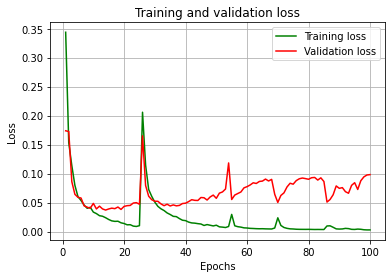

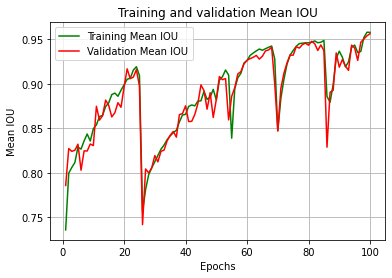

Epoch 1/100
72/72 [==============================] - 66s 805ms/step - loss: 0.3892 - mean_io_u: 0.6688 - val_loss: 0.2021 - val_mean_io_u: 0.7475
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0527_20:30/assets
Epoch 2/100
72/72 [==============================] - 62s 800ms/step - loss: 0.1896 - mean_io_u: 0.7635 - val_loss: 0.1781 - val_mean_io_u: 0.7657
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0527_20:30/assets
Epoch 3/100
72/72 [==============================] - 57s 797ms/step - loss: 0.1865 - mean_io_u: 0.7621 - val_loss: 0.1669 - val_mean_io_u: 0.7564
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/0527_20:30/assets
Epoch 4/100
72/72 [==============================] - 57s 798ms/step - loss: 0.1586 - 

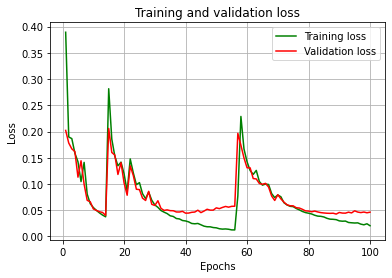

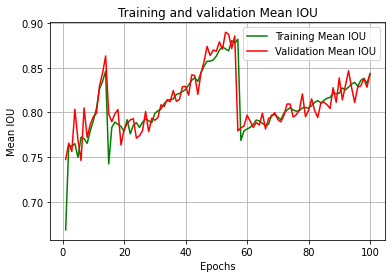

Models Created:  ['0527_20:30']


In [12]:
#Keep training the rest of the ones that didnt finish 
BATCH_SIZE_LIST = [64,128]
all_names = []
for size in BATCH_SIZE_LIST:
  BATCH_SIZE_TRAIN = size
  BATCH_SIZE_VALIDATE = size 

  #Get time for modelname
  now = datetime.now()
  dt_string = now.strftime("%m%d_%H:%M")
  all_names.append(dt_string)

  #Check point and output path 
  checkpoint_filepath = '/content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/' + dt_string + '/'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=False,
      monitor='val_loss',
      mode='auto',
      save_best_only=True)

  # Batches per epoch
  EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
  EPOCH_STEP_VALIDATE = NUM_VALIDATE // BATCH_SIZE_VALIDATE

  #Create/Compile Model 
  model = unet(n_levels= 4, IMAGE_HEIGHT=IMAGE_HEIGHT, IMAGE_WIDTH=IMAGE_WIDTH, out_channels=9)
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [tf.keras.metrics.MeanIoU(num_classes=N_CLASSES)])

  #TRAIN MODEL
  history = model.fit(scaled_train_images, scaled_train_masks, 
                    batch_size = BATCH_SIZE_TRAIN, 
                    steps_per_epoch=EPOCH_STEP_TRAIN,  
                    validation_data=(scaled_validate_images, scaled_validate_masks), 
                    validation_steps=EPOCH_STEP_VALIDATE,
                    epochs = NUM_EPOCH,
                    callbacks=[model_checkpoint_callback])
  
  #plot the train metric history at each epoch
  plot_train_hist(history, plt_acc=False, plt_mean_iou=True)

  #Clear Memory
  tf.keras.backend.clear_session()
  del model

print("Models Created: ", all_names)

In [17]:
BATCH_SIZE_LIST = [12,16,32,64,128]
all_names = ['0527_03:03','0527_04:51','0527_06:35','0527_18:51','0527_20:30']

#Evaluate All Models and Find Best

In [18]:
#Load Testing Images  
test_images        = load_data(data_dir_test_image, isPNG=True, resize=False, NEW_IMG_SIZE=OG_IMG_SIZE)
scaled_test_images = load_data(data_dir_test_image, isPNG=True, resize=True, NEW_IMG_SIZE=IMG_SIZE)


Dimmensions:  (1042, 512, 512)
Data Type  :  <class 'numpy.uint8'>
Size in MB :  260.5





Dimmensions:  (1042, 192, 192)
Data Type  :  <class 'numpy.uint8'>
Size in MB :  36.63




In [19]:
#Test masks but no encoding for calculating IOU
test_masks_no_encode        = load_data(data_dir_test_mask, isPNG=False, resize=False, NEW_IMG_SIZE=OG_IMG_SIZE) 
scaled_test_masks_no_encode = load_data(data_dir_test_mask, isPNG=False, resize=True, NEW_IMG_SIZE=IMG_SIZE)


test_masks_no_encode = np.expand_dims(test_masks_no_encode, axis=3)
scaled_test_masks_no_encode = np.expand_dims(scaled_test_masks_no_encode, axis=3)

print(test_masks_no_encode.shape)
print(scaled_test_masks_no_encode.shape)


Dimmensions:  (1042, 512, 512)
Data Type  :  <class 'numpy.uint8'>
Size in MB :  260.5





Dimmensions:  (1042, 192, 192)
Data Type  :  <class 'numpy.uint8'>
Size in MB :  36.63


(1042, 512, 512, 1)
(1042, 192, 192, 1)


In [20]:
from tensorflow.keras.metrics import MeanIoU
all_mean_ious = []

for model in all_names:
  print('------Model:-------', model, '------------------')
  model_path = '/content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/' + model + '/'
  imported_model = load_model(model_path)

  #IOU
  mask_pred=imported_model.predict(scaled_test_images)
  mask_pred_argmax=np.argmax(mask_pred, axis=3) #Convert the probability into a max value within the area \
  #ex: lets say we have three labels/categories
  # [0,0.1,0] [0,0.05,0] [0,0.9,0] -> [0,0,0] [0,0,0] [0,1,0]

  IOU = MeanIoU(num_classes=N_CLASSES)  
  IOU.update_state(scaled_test_masks_no_encode[:,:,:,0], mask_pred_argmax)
  print("Mean IoU =", IOU.result().numpy())
  all_mean_ious.append(IOU.result().numpy())

  #Get confusion Matrix
  cm = np.array(IOU.get_weights()).reshape(N_CLASSES, N_CLASSES)
  
  #To calculate I0U for each class...
  calculateClassIOU(cm, 9)

  #Clear Memory
  tf.keras.backend.clear_session()
  del model

max_val = max(all_mean_ious)
max_index = all_mean_ious.index(max_val)
best_model = all_names[max_index]
print('\n===========================================')
print('Best Model is: ', best_model)#prev_best= 0.5916435


------Model:------- 0527_03:03 ------------------
Mean IoU = 0.61849916
IoU for class, 0  is:  0.9907549234458718
IoU for class, 1  is:  0.602619423591701
IoU for class, 2  is:  0.6375996957054622
IoU for class, 3  is:  0.4651060196385371
IoU for class, 4  is:  0.5068339800214645
IoU for class, 5  is:  0.5362333625054362
IoU for class, 6  is:  0.5684414892191515
IoU for class, 7  is:  0.6563289554317265
IoU for class, 8  is:  0.6025746611609096
------Model:------- 0527_04:51 ------------------
Mean IoU = 0.6410566
IoU for class, 0  is:  0.9907444506889681
IoU for class, 1  is:  0.6021686976554854
IoU for class, 2  is:  0.6661507931132574
IoU for class, 3  is:  0.5842283948525775
IoU for class, 4  is:  0.5192441952120352
IoU for class, 5  is:  0.5714677205718385
IoU for class, 6  is:  0.5510986679695535
IoU for class, 7  is:  0.6604255975195604
IoU for class, 8  is:  0.6239808645508245
------Model:------- 0527_06:35 ------------------
Mean IoU = 0.6312063
IoU for class, 0  is:  0.990224

#Visualize Results with Best Model

In [21]:
model_path = '/content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/saved_models/All_Slices/' + best_model + '/'
imported_model = load_model(model_path)

mask_pred=imported_model.predict(scaled_test_images)
mask_pred_argmax=np.argmax(mask_pred, axis=3)

Instance in test dataset:  0


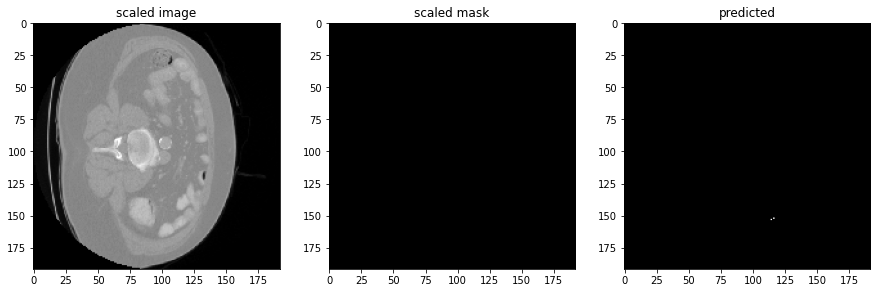

Scaled Mask Unique: [0]
Scaled Mask Unique: [0 5]
Instance in test dataset:  1


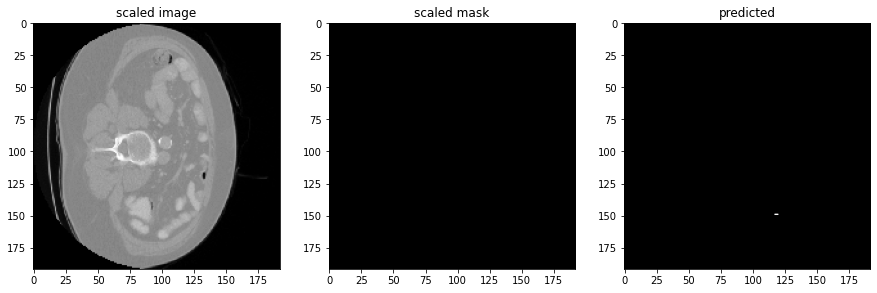

Scaled Mask Unique: [0]
Scaled Mask Unique: [0 5]
Instance in test dataset:  2


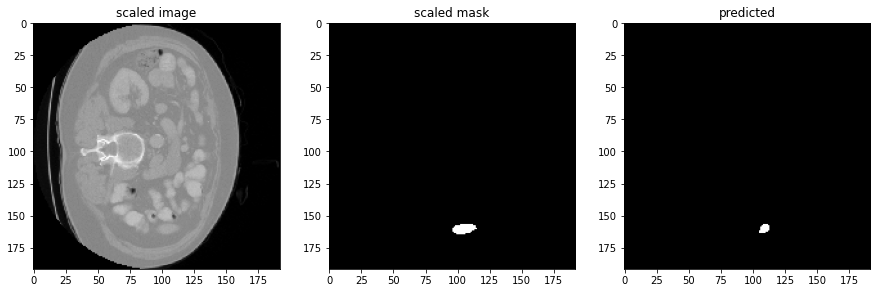

Scaled Mask Unique: [0 5]
Scaled Mask Unique: [0 5]
Instance in test dataset:  3


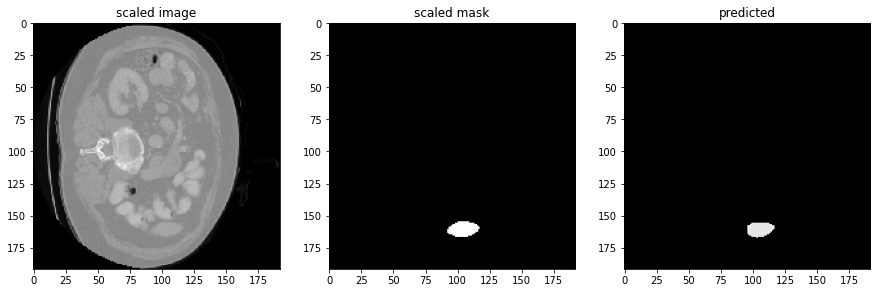

Scaled Mask Unique: [0 5]
Scaled Mask Unique: [0 5 6]
Instance in test dataset:  4


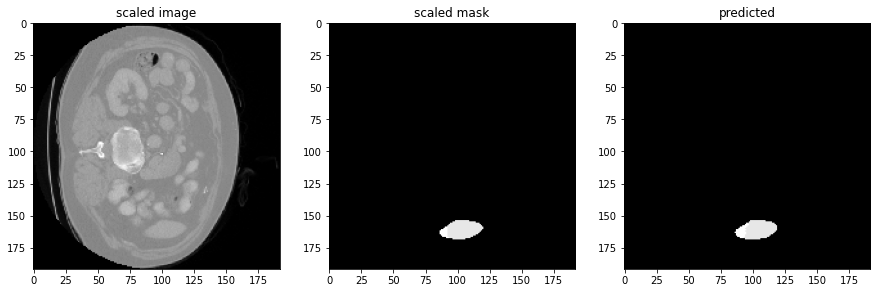

Scaled Mask Unique: [0 5 6]
Scaled Mask Unique: [0 5 6]
Instance in test dataset:  5


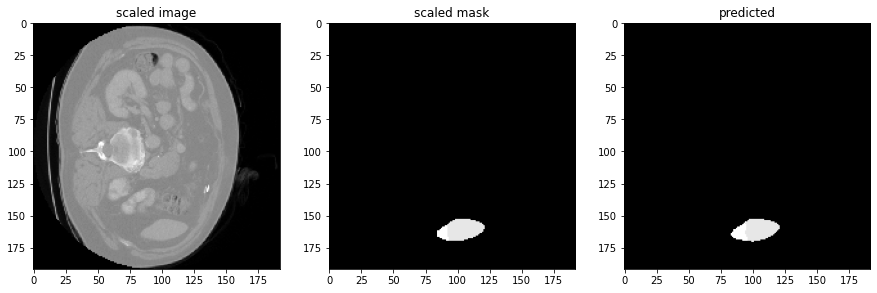

Scaled Mask Unique: [0 5 6]
Scaled Mask Unique: [0 5 6]
Instance in test dataset:  6


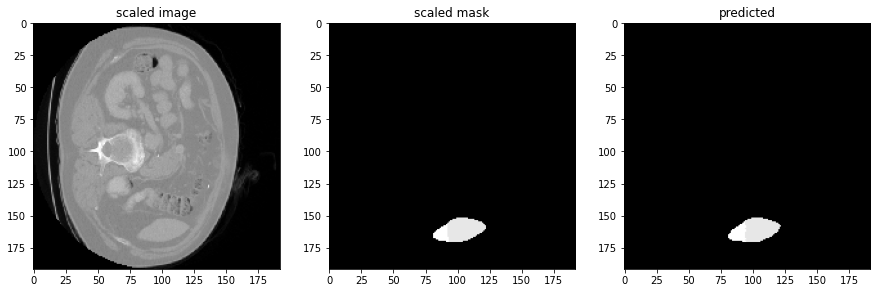

Scaled Mask Unique: [0 5 6]
Scaled Mask Unique: [0 5 6]
Instance in test dataset:  7


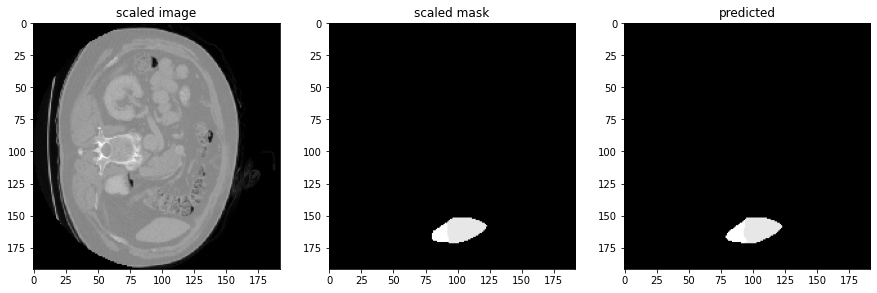

Scaled Mask Unique: [0 5 6]
Scaled Mask Unique: [0 5 6]
Instance in test dataset:  8


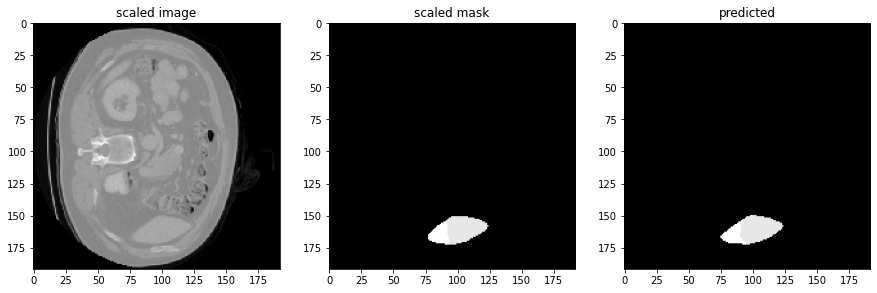

Scaled Mask Unique: [0 5 6]
Scaled Mask Unique: [0 5 6]
Instance in test dataset:  9


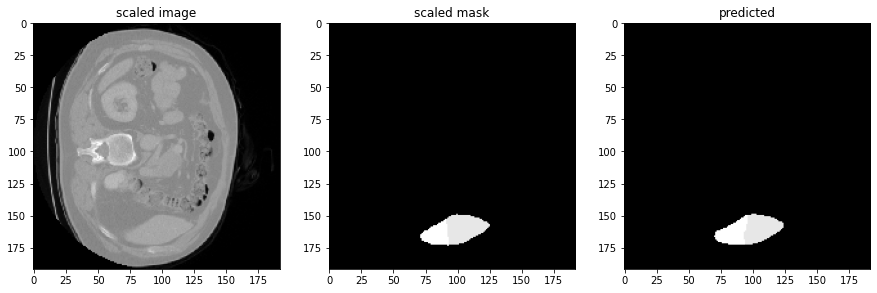

Scaled Mask Unique: [0 5 6]
Scaled Mask Unique: [0 5 6]
Instance in test dataset:  10


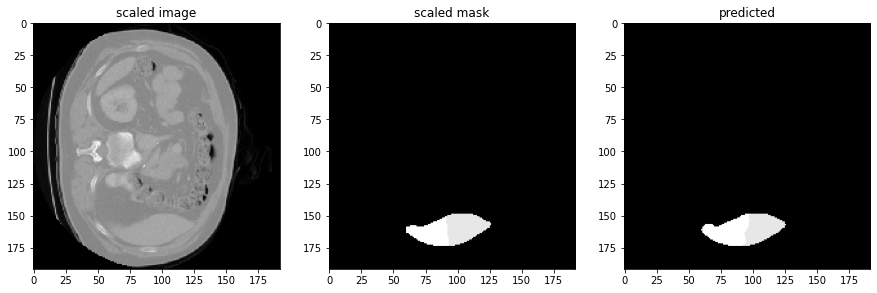

Scaled Mask Unique: [0 5 6]
Scaled Mask Unique: [0 5 6]
Instance in test dataset:  11


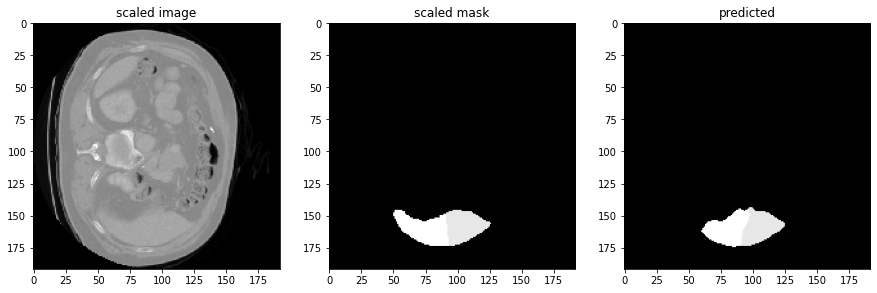

Scaled Mask Unique: [0 5 6]
Scaled Mask Unique: [0 5 6]
Instance in test dataset:  12


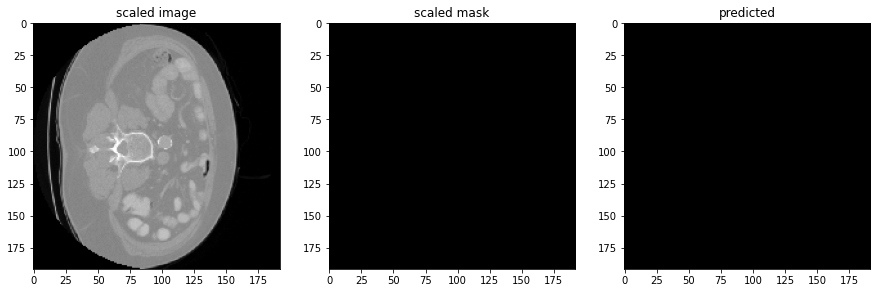

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]
Instance in test dataset:  13


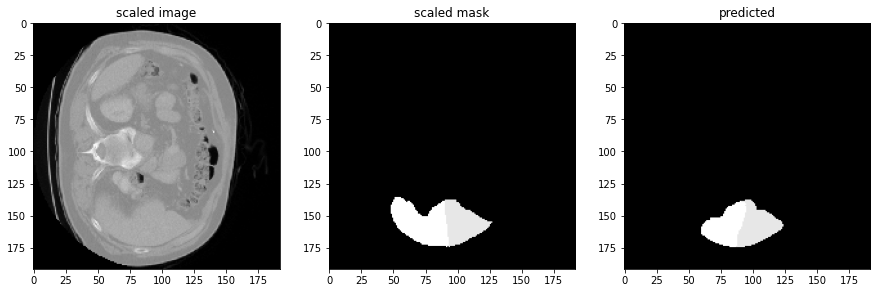

Scaled Mask Unique: [0 5 6]
Scaled Mask Unique: [0 5 6]
Instance in test dataset:  14


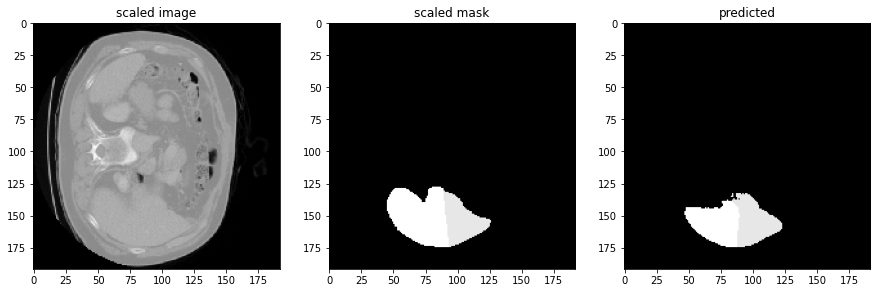

Scaled Mask Unique: [0 5 6]
Scaled Mask Unique: [0 5 6]
Instance in test dataset:  15


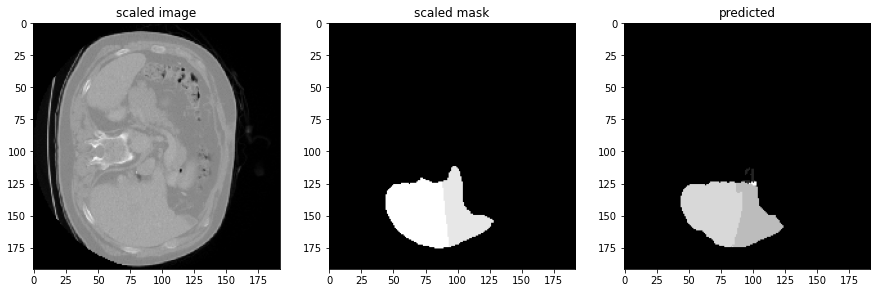

Scaled Mask Unique: [0 5 6]
Scaled Mask Unique: [0 1 4 5 6 8]
Instance in test dataset:  16


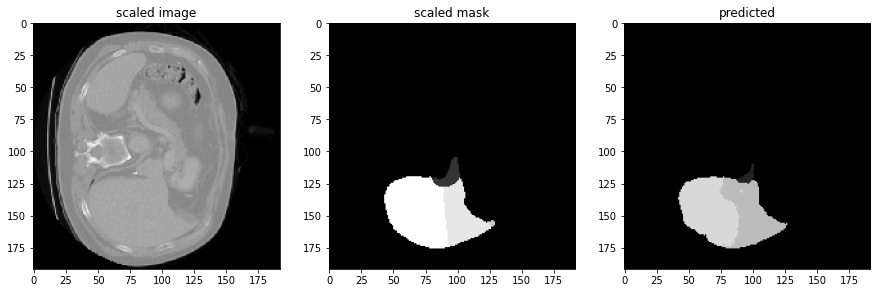

Scaled Mask Unique: [0 1 4 5 6]
Scaled Mask Unique: [0 1 5 6 8]
Instance in test dataset:  17


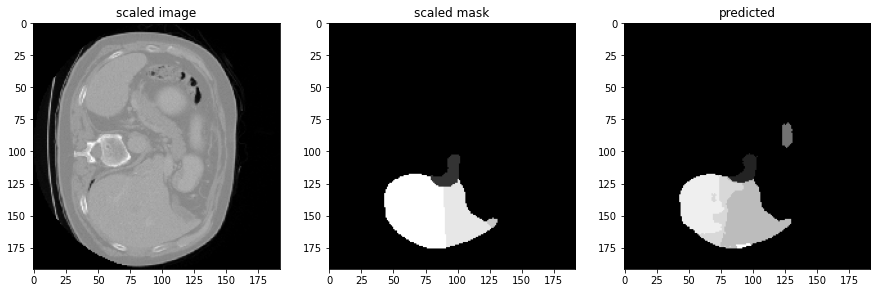

Scaled Mask Unique: [0 1 4 5 6]
Scaled Mask Unique: [0 1 3 5 6 7 8]
Instance in test dataset:  18


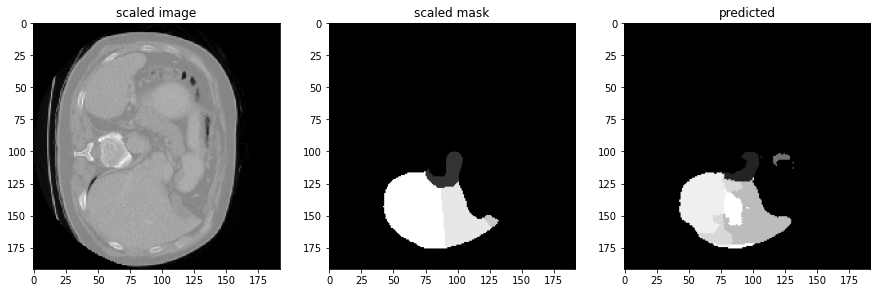

Scaled Mask Unique: [0 1 4 5 6]
Scaled Mask Unique: [0 1 3 4 5 6 7 8]
Instance in test dataset:  19


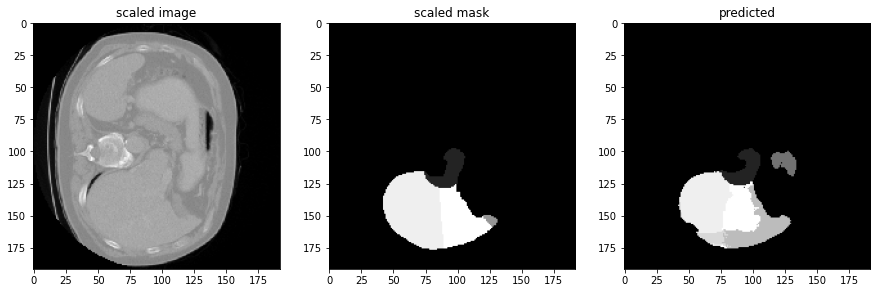

Scaled Mask Unique: [0 1 4 7 8]
Scaled Mask Unique: [0 1 3 4 5 6 7 8]
Instance in test dataset:  20


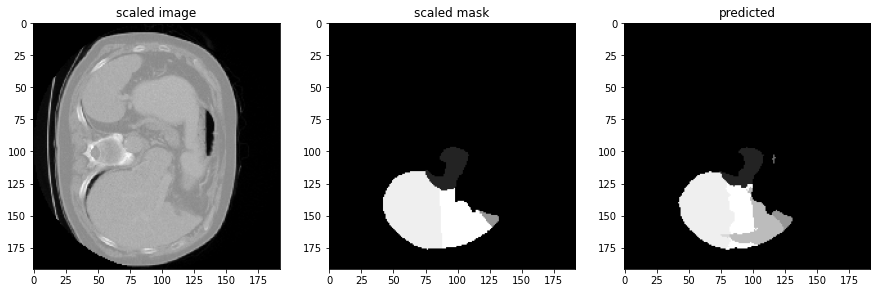

Scaled Mask Unique: [0 1 4 7 8]
Scaled Mask Unique: [0 1 3 4 5 6 7 8]
Instance in test dataset:  21


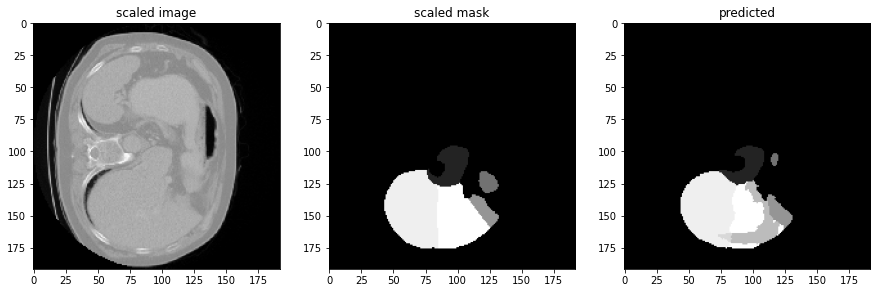

Scaled Mask Unique: [0 1 3 4 7 8]
Scaled Mask Unique: [0 1 3 4 5 6 7 8]
Instance in test dataset:  22


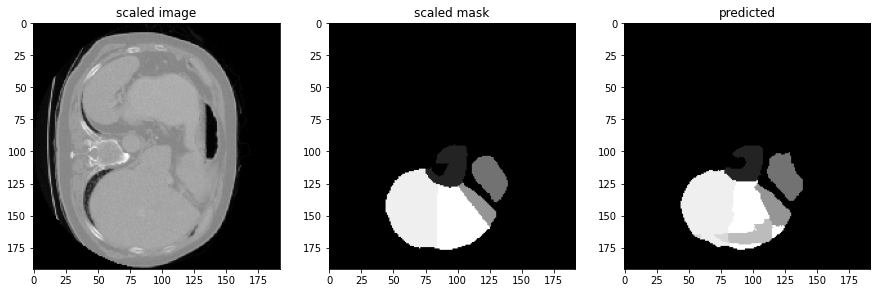

Scaled Mask Unique: [0 1 3 4 7 8]
Scaled Mask Unique: [0 1 3 4 5 6 7 8]
Instance in test dataset:  23


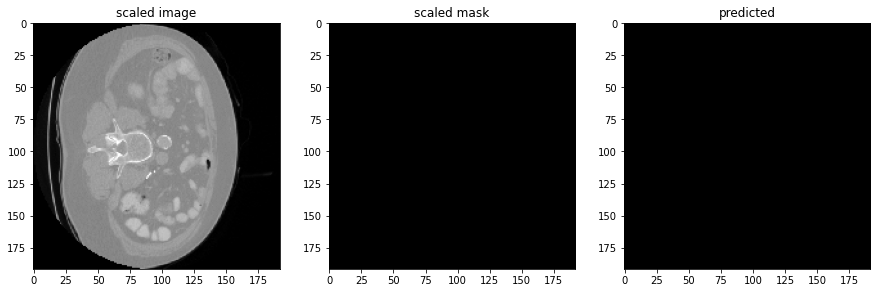

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]
Instance in test dataset:  24


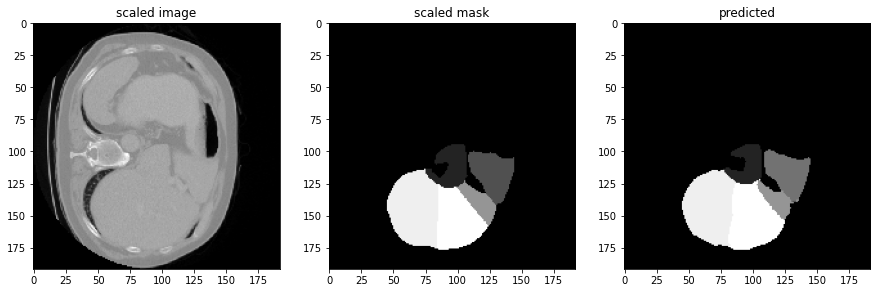

Scaled Mask Unique: [0 1 2 4 7 8]
Scaled Mask Unique: [0 1 2 3 4 7 8]
Instance in test dataset:  25


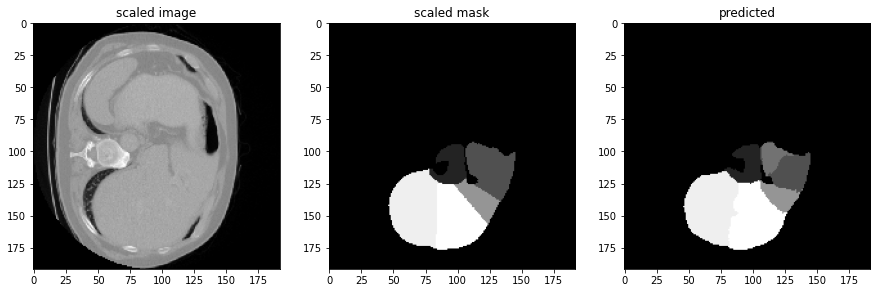

Scaled Mask Unique: [0 1 2 4 7 8]
Scaled Mask Unique: [0 1 2 3 4 7 8]
Instance in test dataset:  26


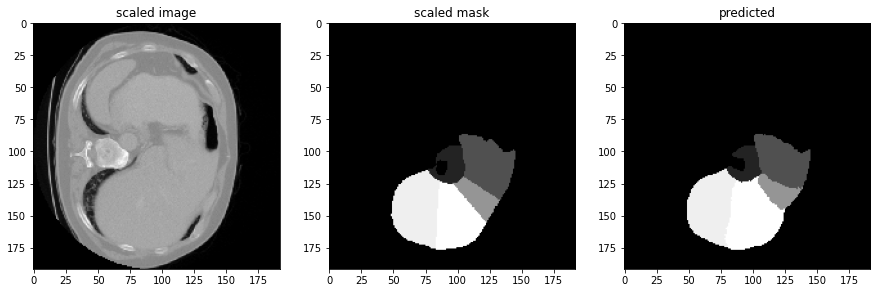

Scaled Mask Unique: [0 1 2 4 7 8]
Scaled Mask Unique: [0 1 2 4 7 8]
Instance in test dataset:  27


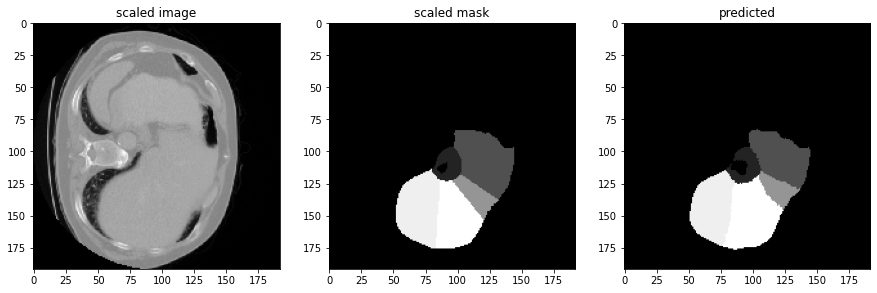

Scaled Mask Unique: [0 1 2 4 7 8]
Scaled Mask Unique: [0 1 2 4 7 8]
Instance in test dataset:  28


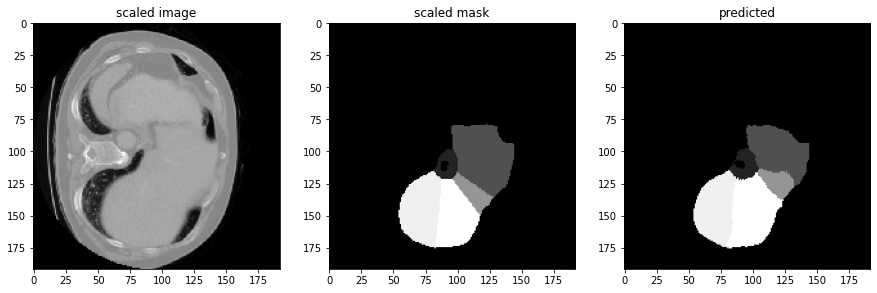

Scaled Mask Unique: [0 1 2 4 7 8]
Scaled Mask Unique: [0 1 2 4 5 6 7 8]
Instance in test dataset:  29


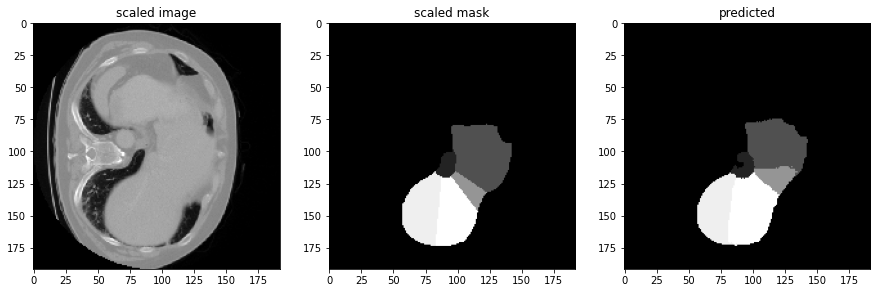

Scaled Mask Unique: [0 1 2 4 7 8]
Scaled Mask Unique: [0 1 2 4 7 8]
Instance in test dataset:  30


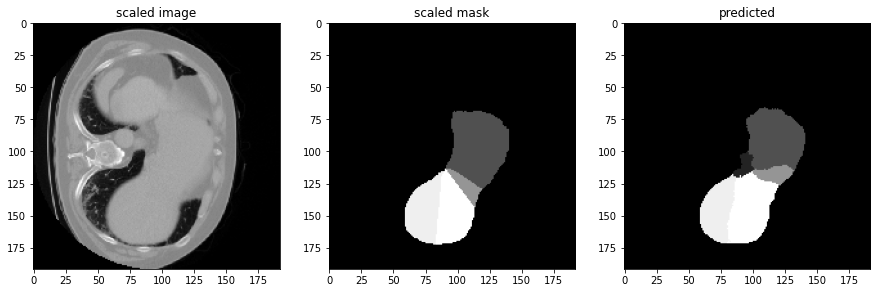

Scaled Mask Unique: [0 2 4 7 8]
Scaled Mask Unique: [0 1 2 4 7 8]
Instance in test dataset:  31


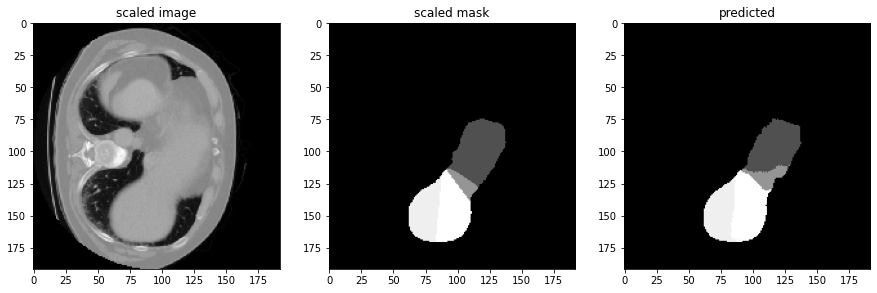

Scaled Mask Unique: [0 2 4 7 8]
Scaled Mask Unique: [0 2 4 7 8]
Instance in test dataset:  32


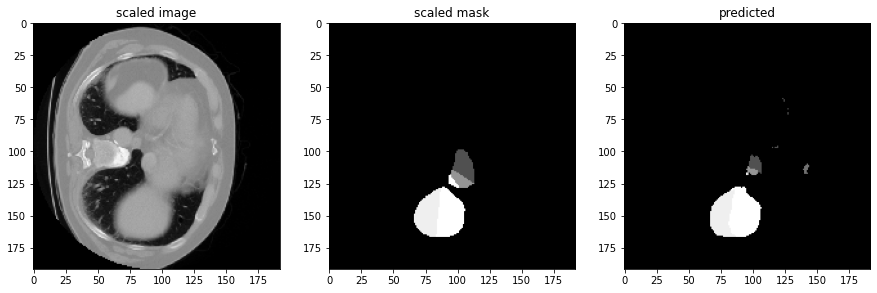

Scaled Mask Unique: [0 2 4 7 8]
Scaled Mask Unique: [0 2 3 4 7 8]
Instance in test dataset:  33


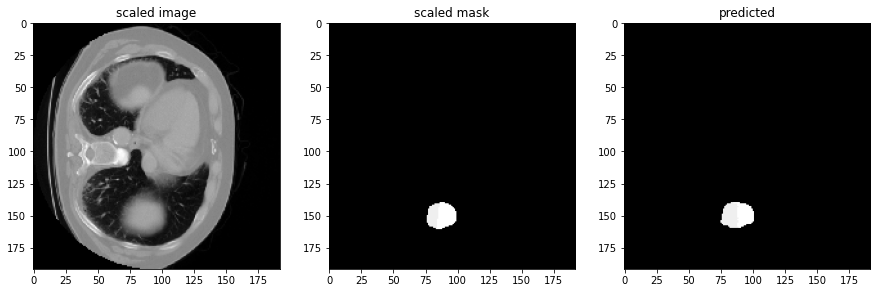

Scaled Mask Unique: [0 7 8]
Scaled Mask Unique: [0 7 8]
Instance in test dataset:  34


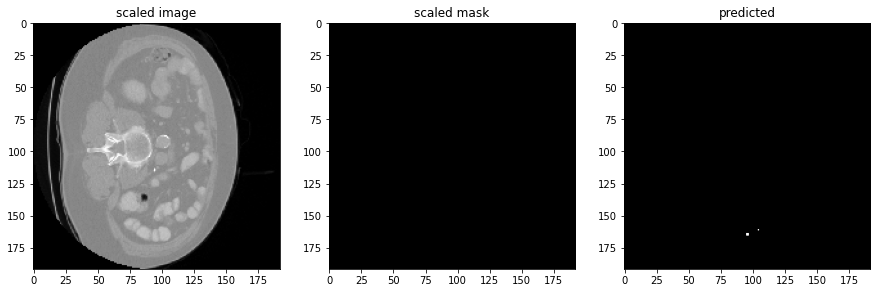

Scaled Mask Unique: [0]
Scaled Mask Unique: [0 5]
Instance in test dataset:  35


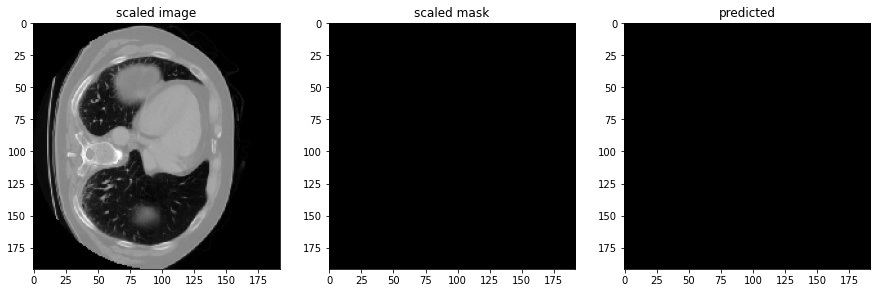

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]
Instance in test dataset:  36


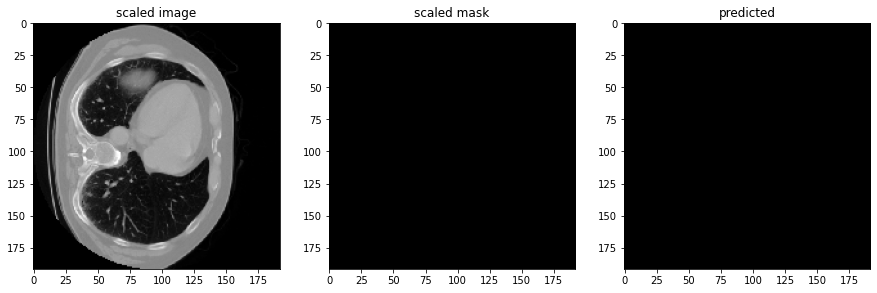

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]
Instance in test dataset:  37


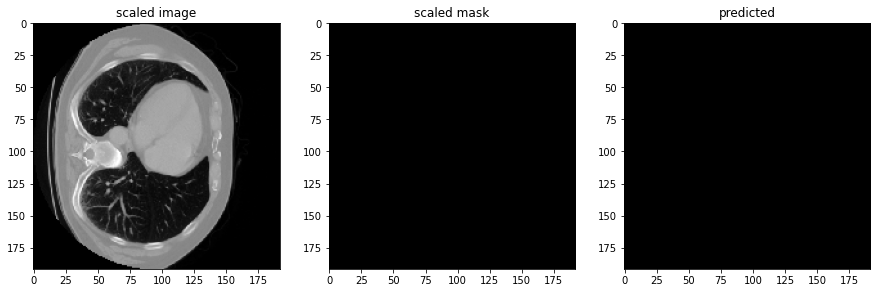

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]
Instance in test dataset:  38


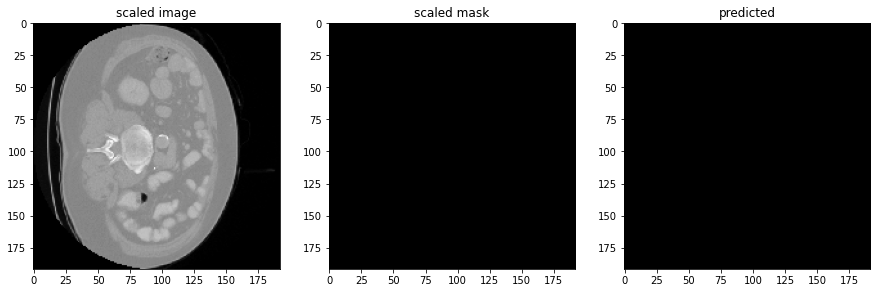

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]
Instance in test dataset:  39


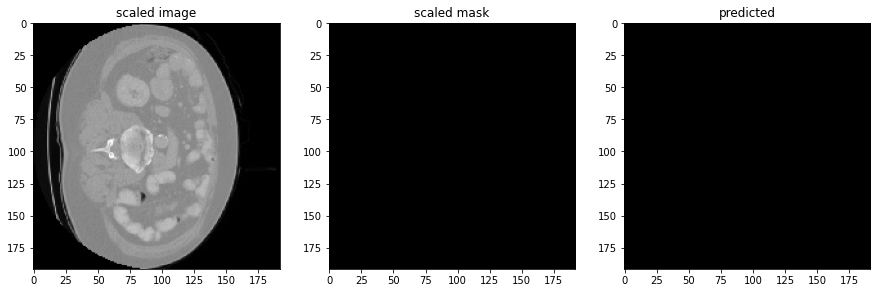

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]
Instance in test dataset:  40


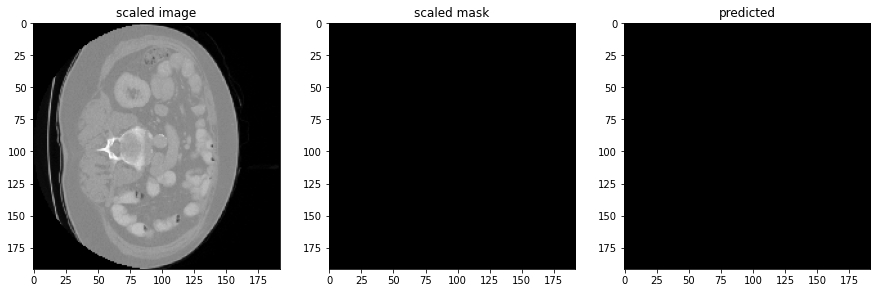

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]
Instance in test dataset:  41


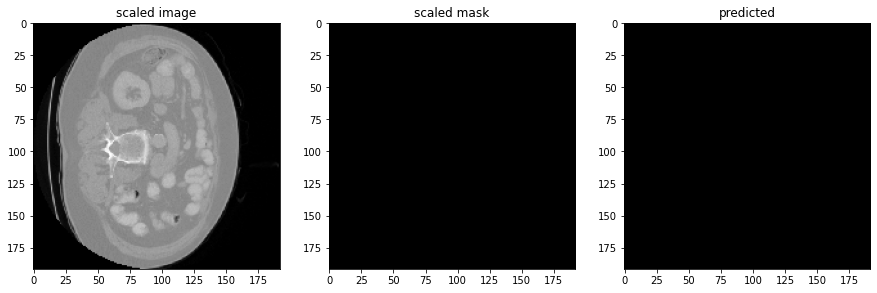

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]
Instance in test dataset:  42


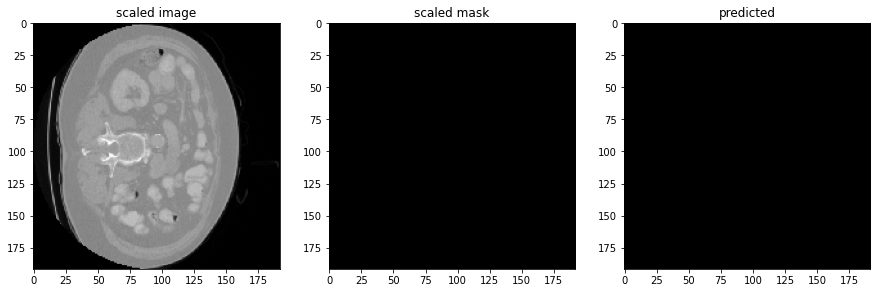

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]
Instance in test dataset:  43


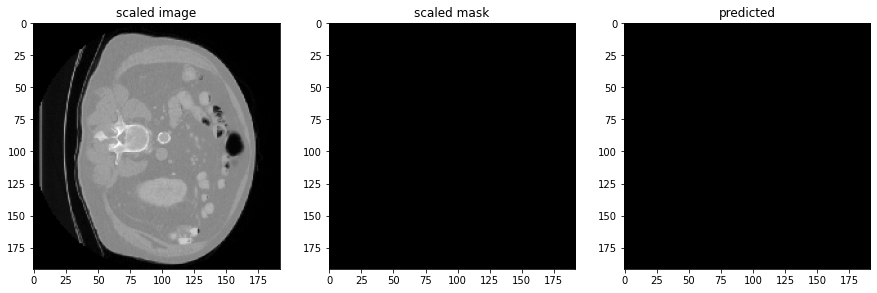

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]
Instance in test dataset:  44


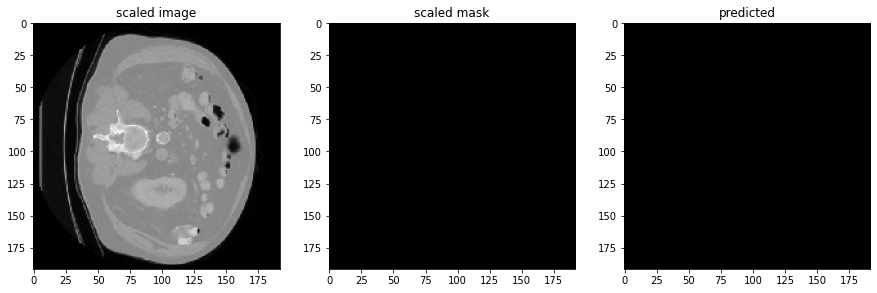

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]
Instance in test dataset:  45


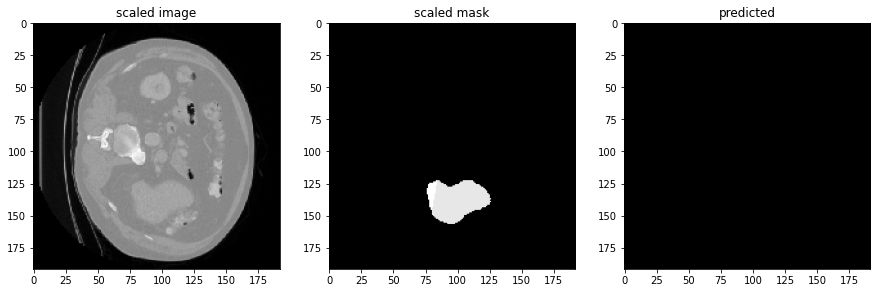

Scaled Mask Unique: [0 5 6]
Scaled Mask Unique: [0]
Instance in test dataset:  46


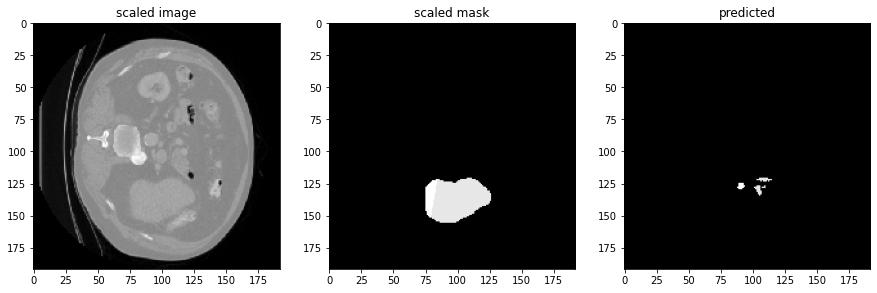

Scaled Mask Unique: [0 5 6]
Scaled Mask Unique: [0 5 6]
Instance in test dataset:  47


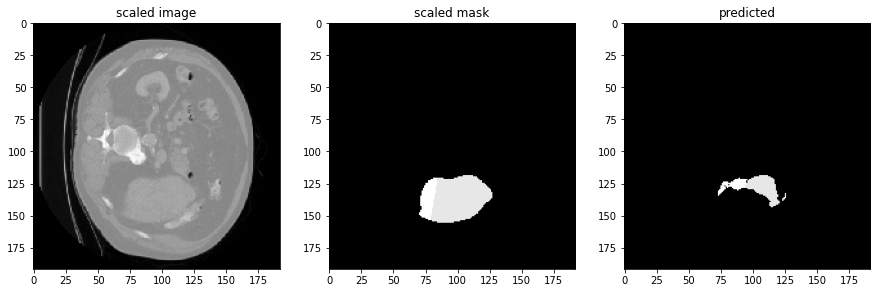

Scaled Mask Unique: [0 5 6]
Scaled Mask Unique: [0 5 6]
Instance in test dataset:  48


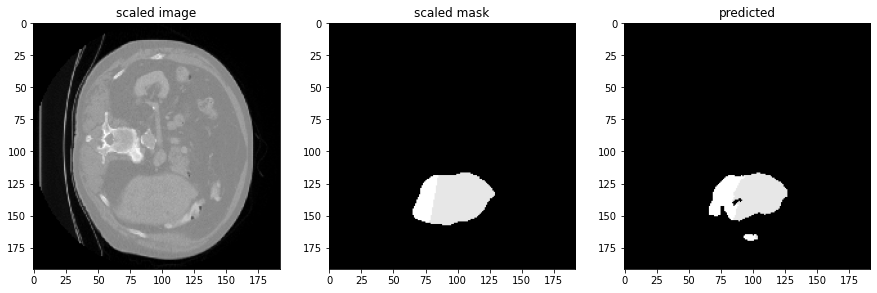

Scaled Mask Unique: [0 5 6]
Scaled Mask Unique: [0 5 6]
Instance in test dataset:  49


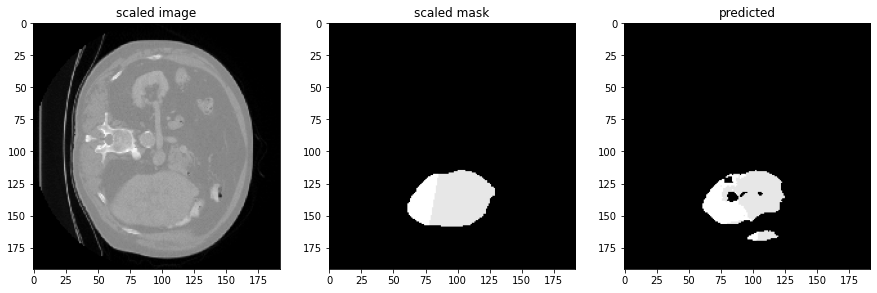

Scaled Mask Unique: [0 5 6]
Scaled Mask Unique: [0 5 6]
Instance in test dataset:  50


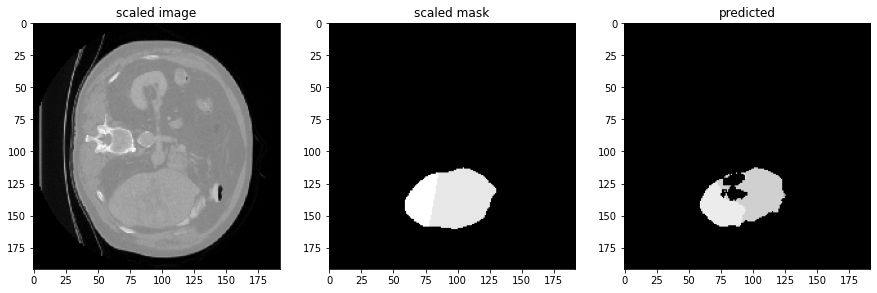

Scaled Mask Unique: [0 5 6]
Scaled Mask Unique: [0 4 5 6 7]
Instance in test dataset:  51


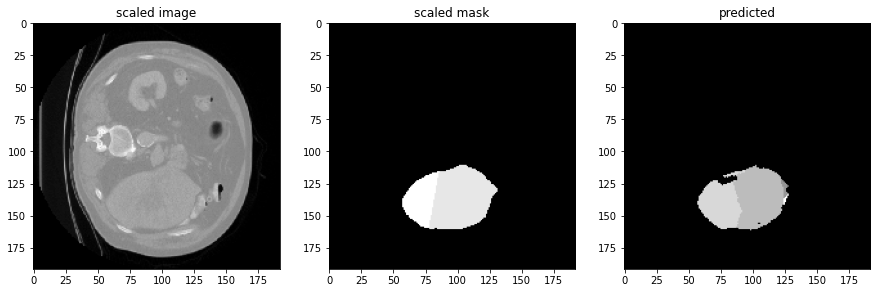

Scaled Mask Unique: [0 5 6]
Scaled Mask Unique: [0 4 5 6 8]
Instance in test dataset:  52


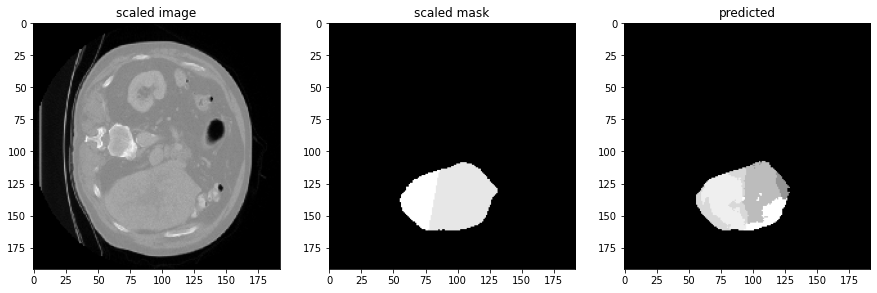

Scaled Mask Unique: [0 5 6]
Scaled Mask Unique: [0 4 5 6 7 8]
Instance in test dataset:  53


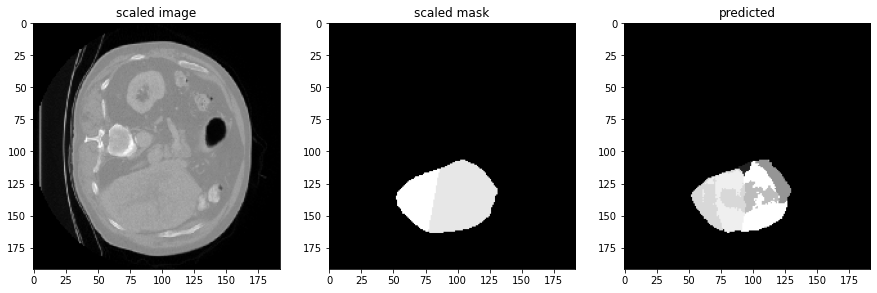

Scaled Mask Unique: [0 5 6]
Scaled Mask Unique: [0 1 2 4 5 6 7 8]
Instance in test dataset:  54


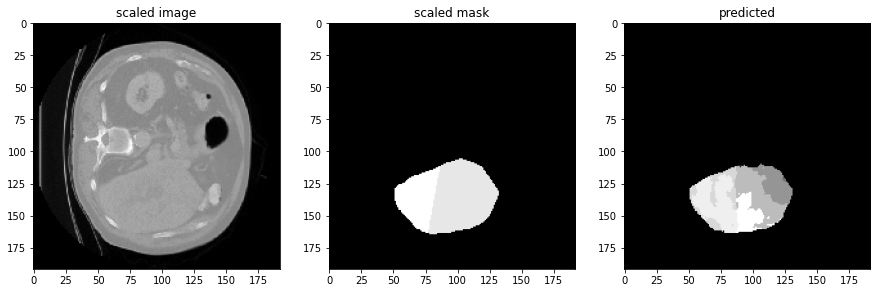

Scaled Mask Unique: [0 5 6]
Scaled Mask Unique: [0 1 3 4 5 6 7 8]
Instance in test dataset:  55


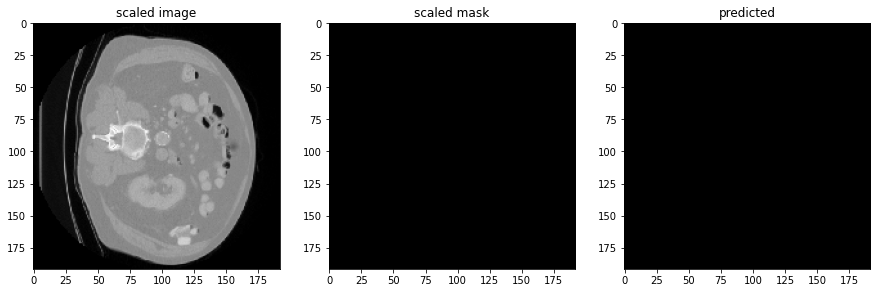

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]
Instance in test dataset:  56


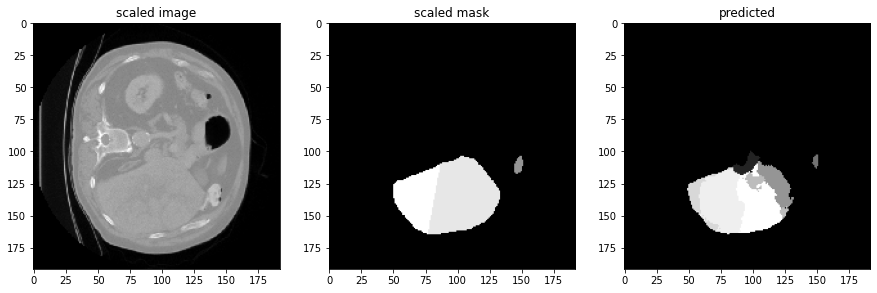

Scaled Mask Unique: [0 3 5 6]
Scaled Mask Unique: [0 1 3 4 5 6 7 8]
Instance in test dataset:  57


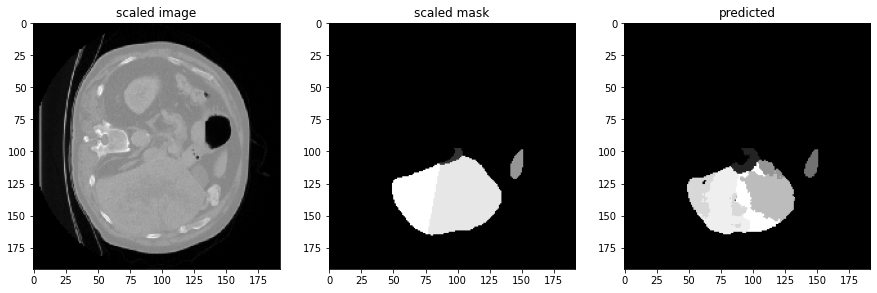

Scaled Mask Unique: [0 1 3 5 6]
Scaled Mask Unique: [0 1 3 4 5 6 7 8]
Instance in test dataset:  58


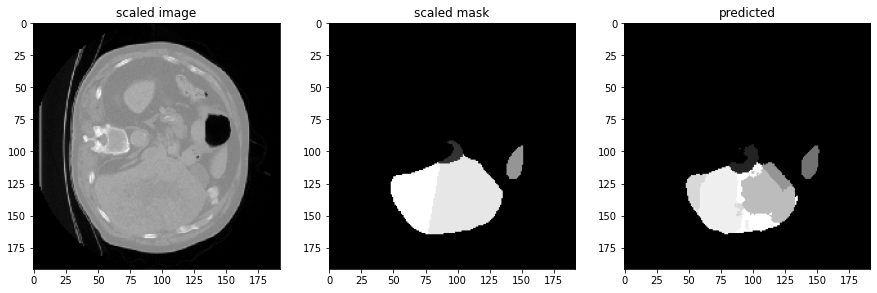

Scaled Mask Unique: [0 1 3 5 6]
Scaled Mask Unique: [0 1 3 4 5 6 7 8]
Instance in test dataset:  59


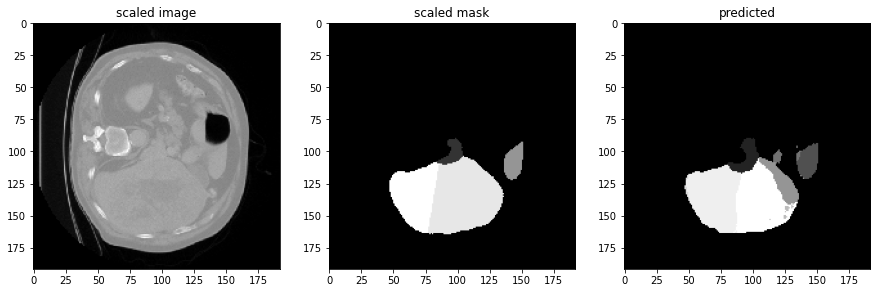

Scaled Mask Unique: [0 1 3 5 6]
Scaled Mask Unique: [0 1 2 3 4 5 6 7 8]
Instance in test dataset:  60


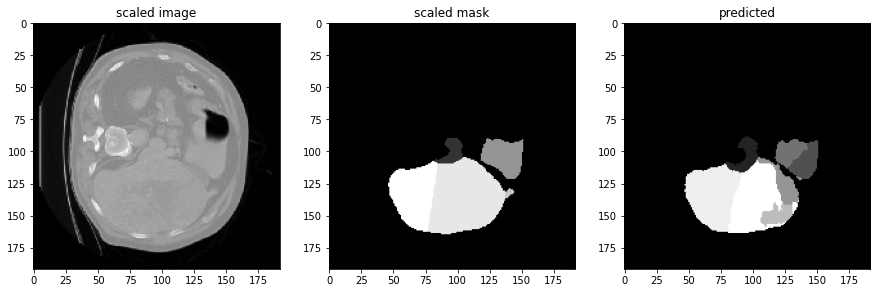

Scaled Mask Unique: [0 1 3 4 5 6]
Scaled Mask Unique: [0 1 2 3 4 5 7 8]
Instance in test dataset:  61


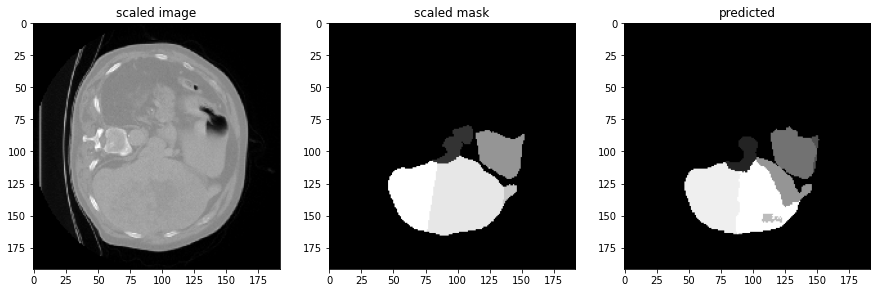

Scaled Mask Unique: [0 1 3 4 5 6]
Scaled Mask Unique: [0 1 2 3 4 5 6 7 8]
Instance in test dataset:  62


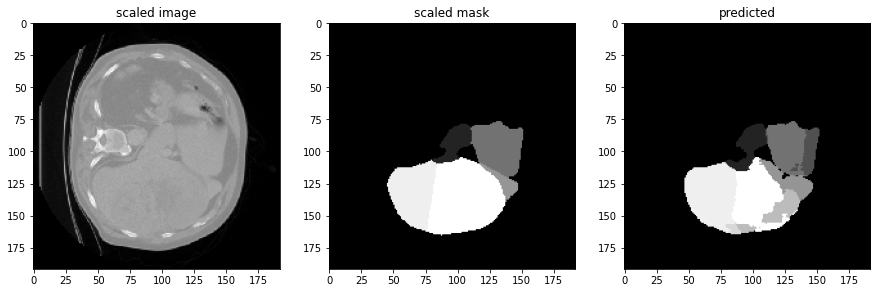

Scaled Mask Unique: [0 1 3 4 7 8]
Scaled Mask Unique: [0 1 2 3 4 5 6 7 8]
Instance in test dataset:  63


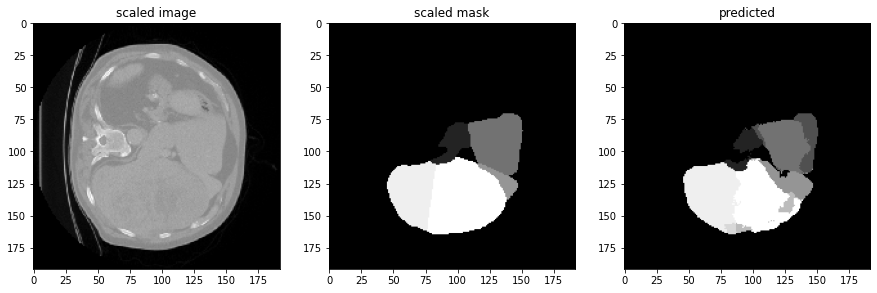

Scaled Mask Unique: [0 1 3 4 7 8]
Scaled Mask Unique: [0 1 2 3 4 5 6 7 8]
Instance in test dataset:  64


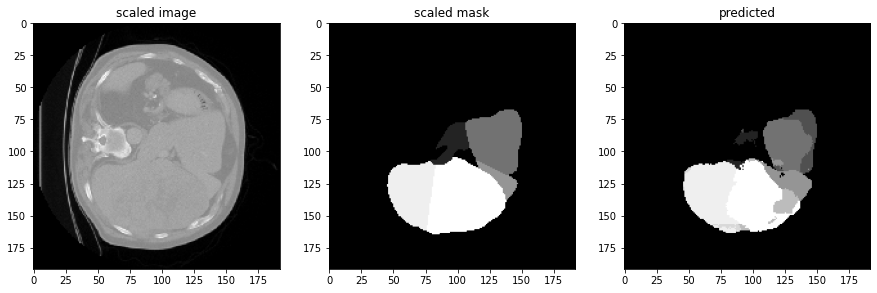

Scaled Mask Unique: [0 1 3 4 7 8]
Scaled Mask Unique: [0 1 2 3 4 5 6 7 8]
Instance in test dataset:  65


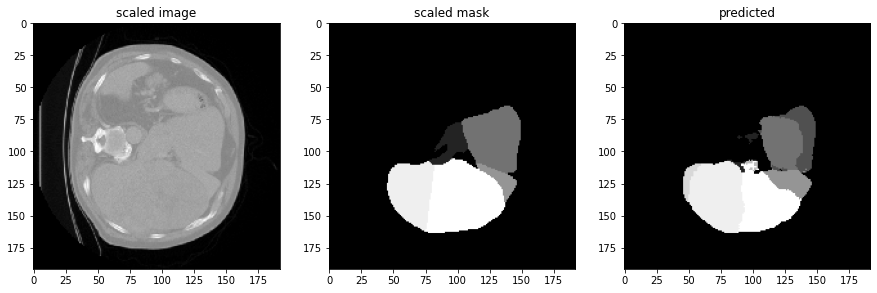

Scaled Mask Unique: [0 1 3 4 7 8]
Scaled Mask Unique: [0 1 2 3 4 5 6 7 8]
Instance in test dataset:  66


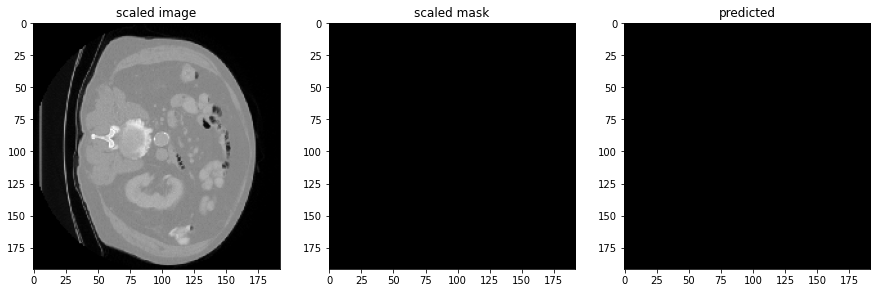

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]
Instance in test dataset:  67


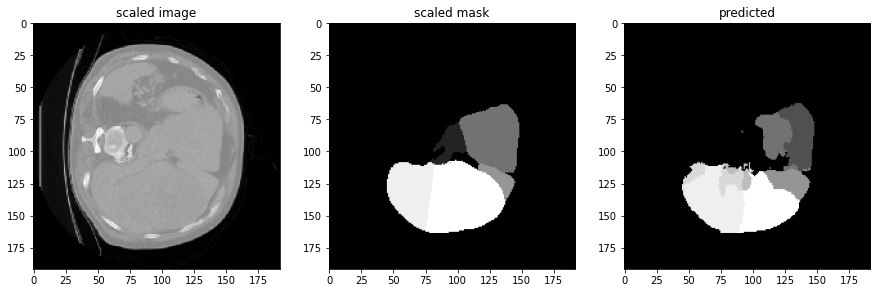

Scaled Mask Unique: [0 1 3 4 7 8]
Scaled Mask Unique: [0 1 2 3 4 5 6 7 8]
Instance in test dataset:  68


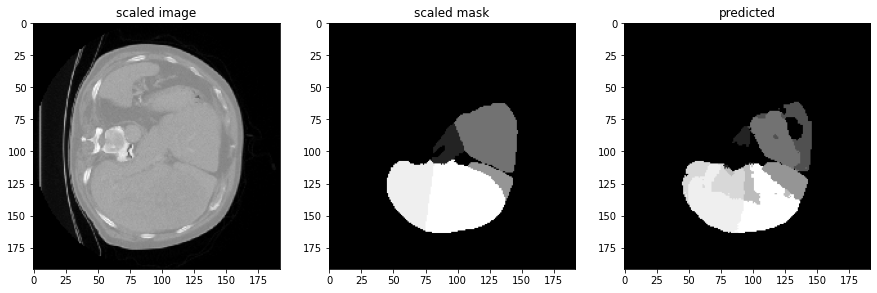

Scaled Mask Unique: [0 1 3 4 7 8]
Scaled Mask Unique: [0 1 2 3 4 5 6 7 8]
Instance in test dataset:  69


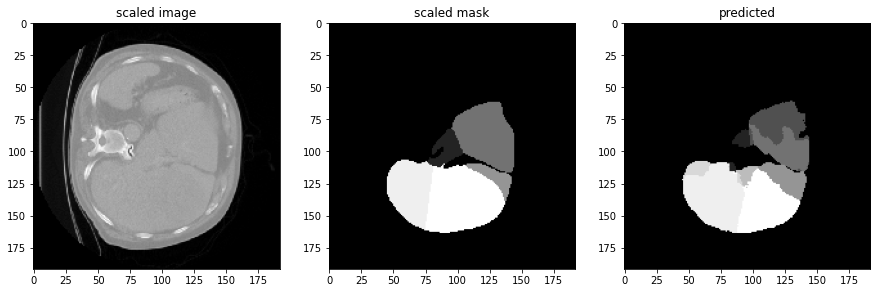

Scaled Mask Unique: [0 1 3 4 7 8]
Scaled Mask Unique: [0 1 2 3 4 5 6 7 8]
Instance in test dataset:  70


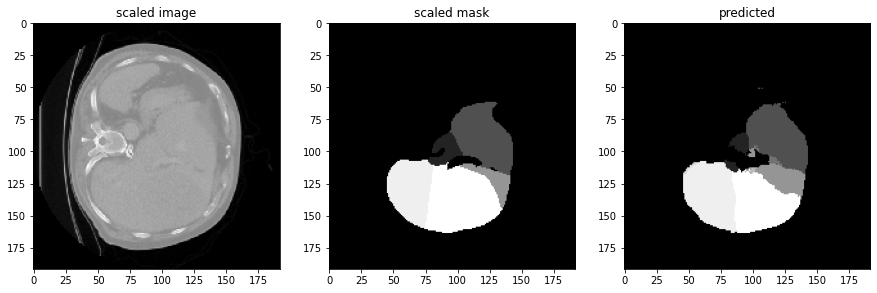

Scaled Mask Unique: [0 1 2 4 7 8]
Scaled Mask Unique: [0 1 2 3 4 5 6 7 8]
Instance in test dataset:  71


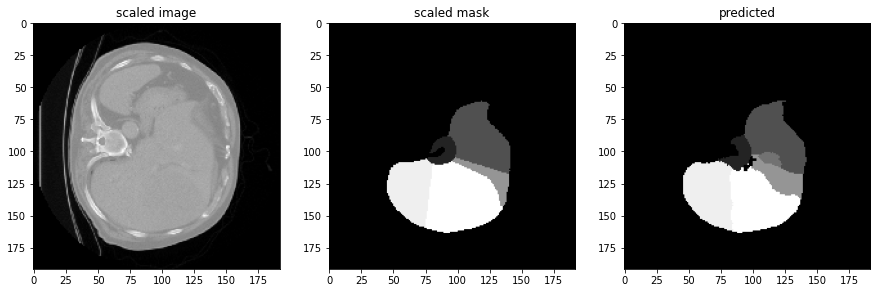

Scaled Mask Unique: [0 1 2 4 7 8]
Scaled Mask Unique: [0 1 2 3 4 6 7 8]
Instance in test dataset:  72


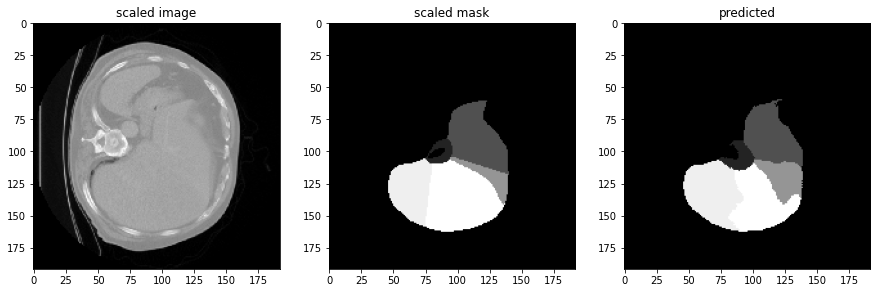

Scaled Mask Unique: [0 1 2 4 7 8]
Scaled Mask Unique: [0 1 2 4 7 8]
Instance in test dataset:  73


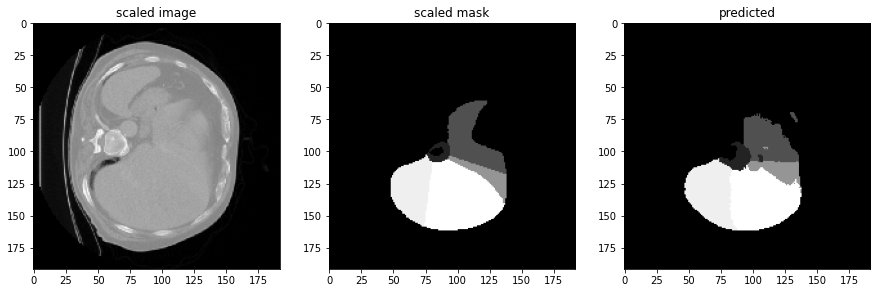

Scaled Mask Unique: [0 1 2 4 7 8]
Scaled Mask Unique: [0 1 2 4 7 8]
Instance in test dataset:  74


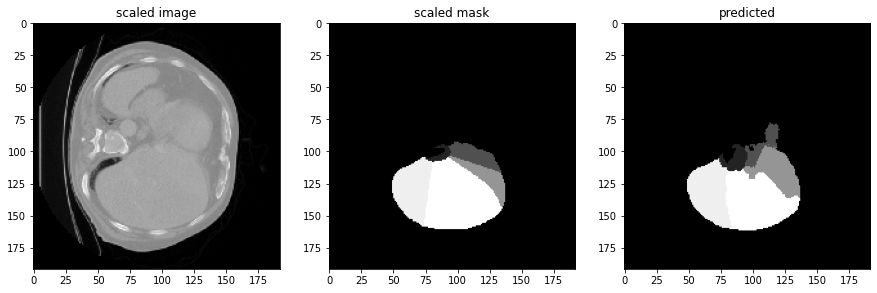

Scaled Mask Unique: [0 1 2 4 7 8]
Scaled Mask Unique: [0 1 2 3 4 7 8]
Instance in test dataset:  75


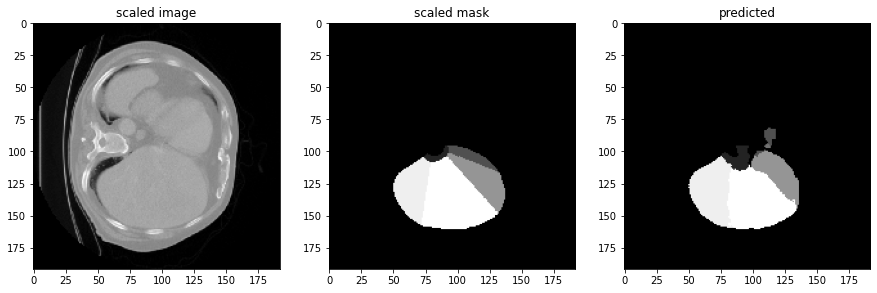

Scaled Mask Unique: [0 1 2 4 7 8]
Scaled Mask Unique: [0 1 2 3 4 7 8]
Instance in test dataset:  76


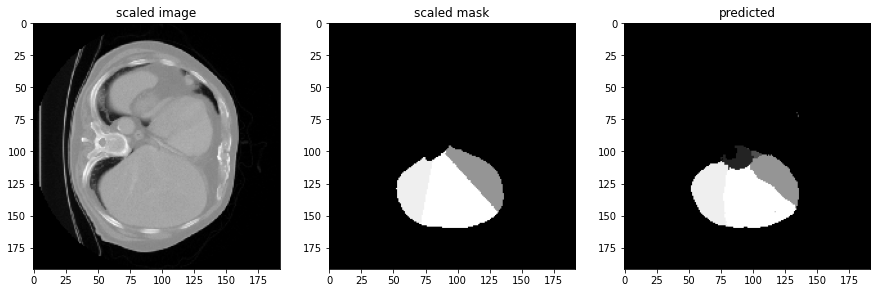

Scaled Mask Unique: [0 4 7 8]
Scaled Mask Unique: [0 1 2 4 5 7 8]
Instance in test dataset:  77


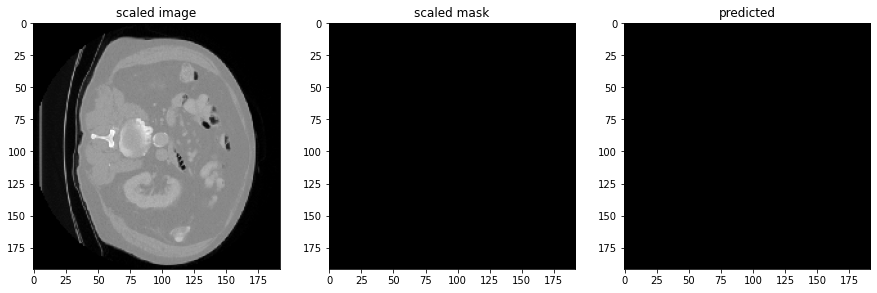

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]
Instance in test dataset:  78


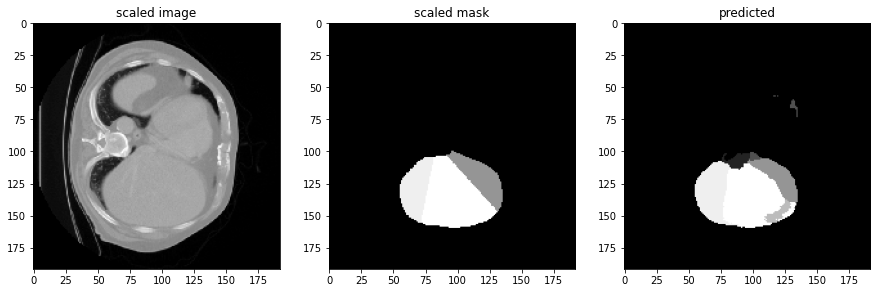

Scaled Mask Unique: [0 4 7 8]
Scaled Mask Unique: [0 1 2 4 5 7 8]
Instance in test dataset:  79


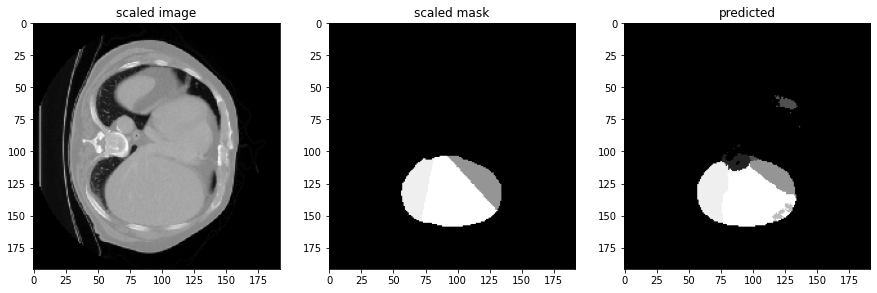

Scaled Mask Unique: [0 4 7 8]
Scaled Mask Unique: [0 1 2 4 5 7 8]
Instance in test dataset:  80


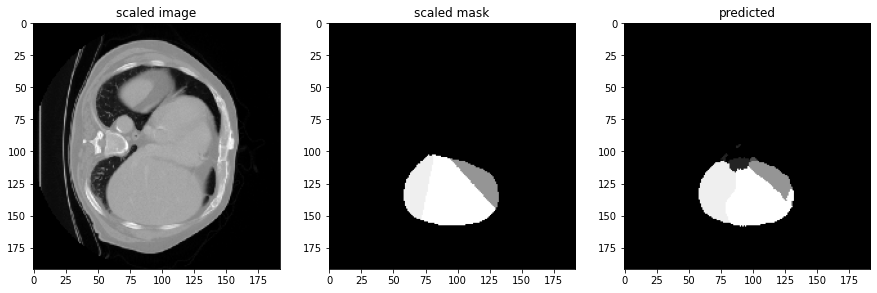

Scaled Mask Unique: [0 4 7 8]
Scaled Mask Unique: [0 1 2 4 7 8]
Instance in test dataset:  81


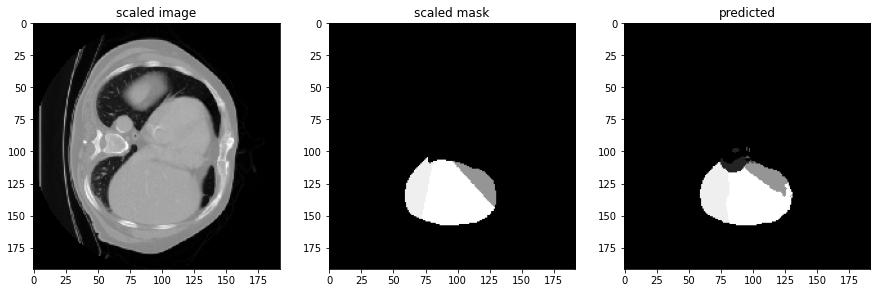

Scaled Mask Unique: [0 4 7 8]
Scaled Mask Unique: [0 1 2 4 7 8]
Instance in test dataset:  82


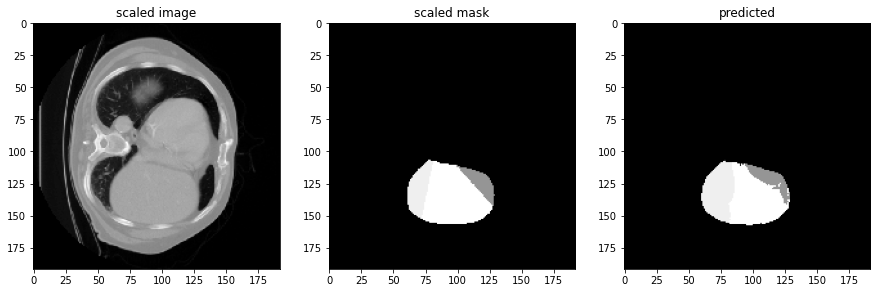

Scaled Mask Unique: [0 4 7 8]
Scaled Mask Unique: [0 1 4 7 8]
Instance in test dataset:  83


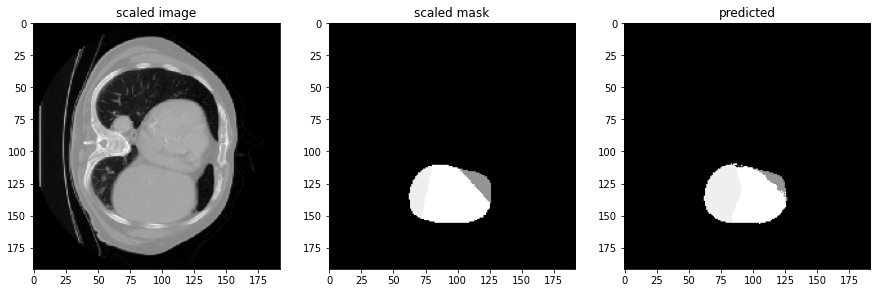

Scaled Mask Unique: [0 4 7 8]
Scaled Mask Unique: [0 1 4 7 8]
Instance in test dataset:  84


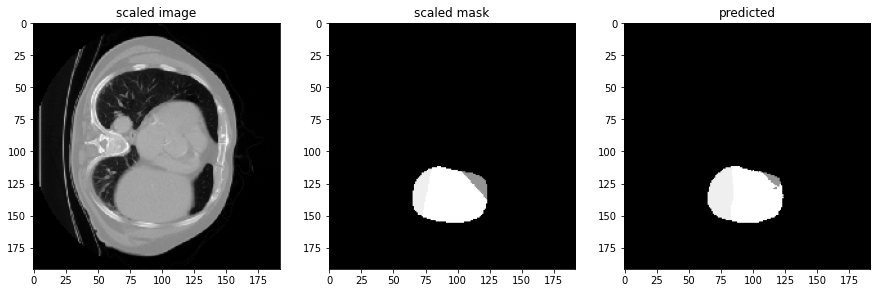

Scaled Mask Unique: [0 4 7 8]
Scaled Mask Unique: [0 4 7 8]
Instance in test dataset:  85


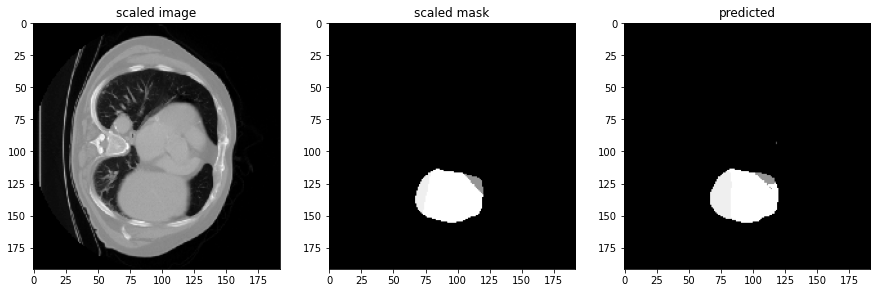

Scaled Mask Unique: [0 4 7 8]
Scaled Mask Unique: [0 2 4 7 8]
Instance in test dataset:  86


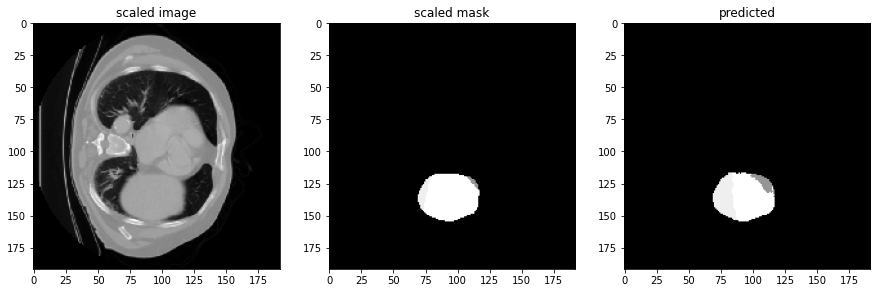

Scaled Mask Unique: [0 4 7 8]
Scaled Mask Unique: [0 4 7 8]
Instance in test dataset:  87


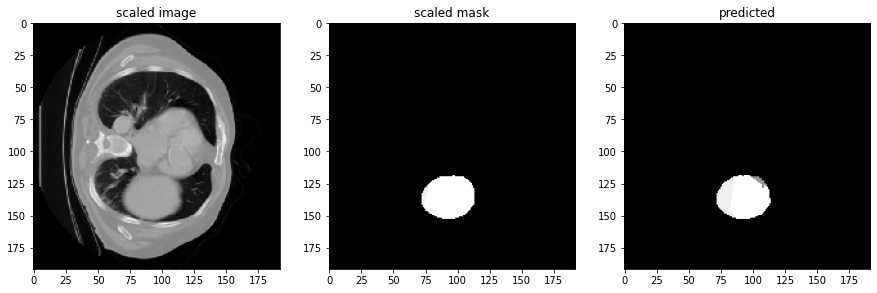

Scaled Mask Unique: [0 7 8]
Scaled Mask Unique: [0 4 7 8]
Instance in test dataset:  88


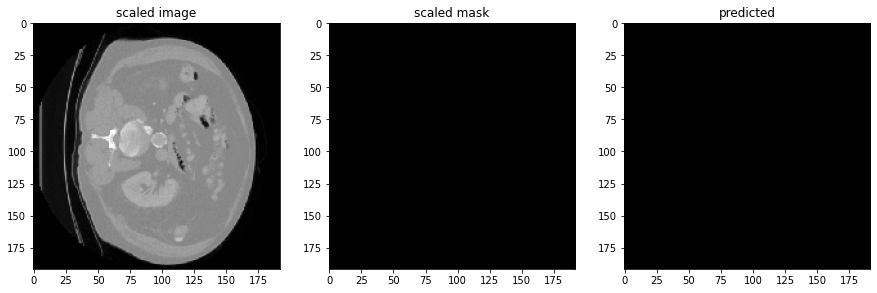

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]
Instance in test dataset:  89


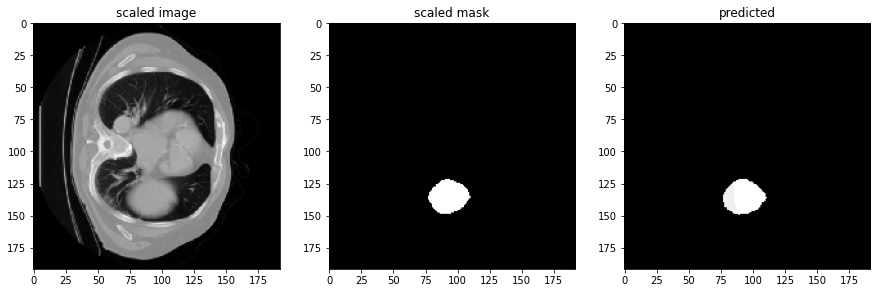

Scaled Mask Unique: [0 8]
Scaled Mask Unique: [0 4 7 8]
Instance in test dataset:  90


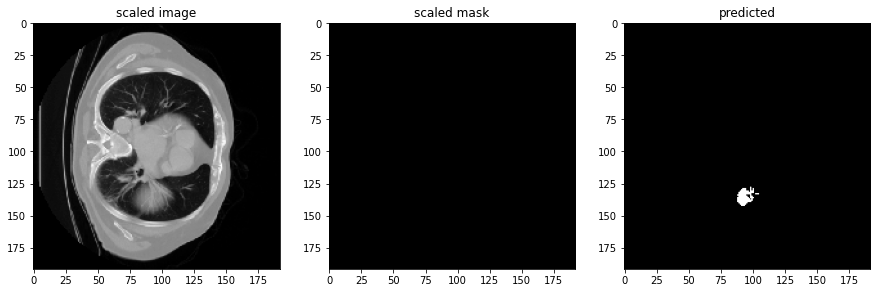

Scaled Mask Unique: [0]
Scaled Mask Unique: [0 8]
Instance in test dataset:  91


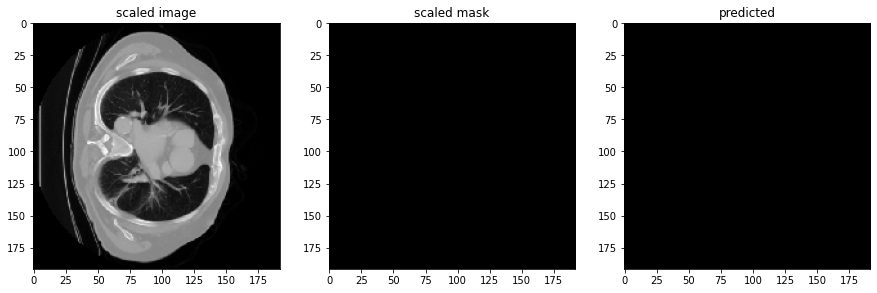

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]
Instance in test dataset:  92


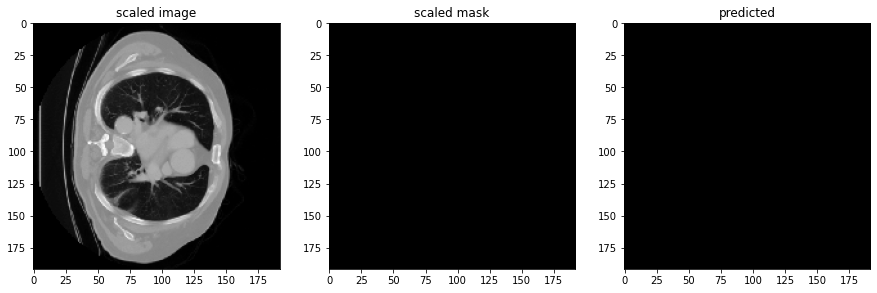

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]
Instance in test dataset:  93


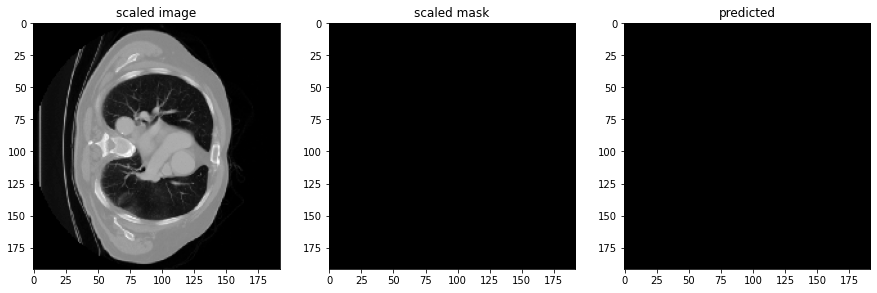

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]
Instance in test dataset:  94


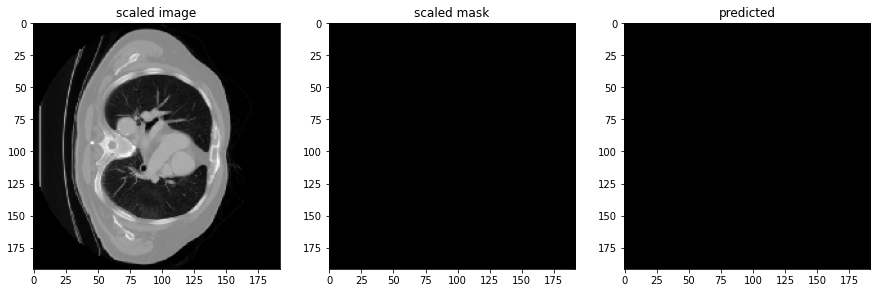

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]
Instance in test dataset:  95


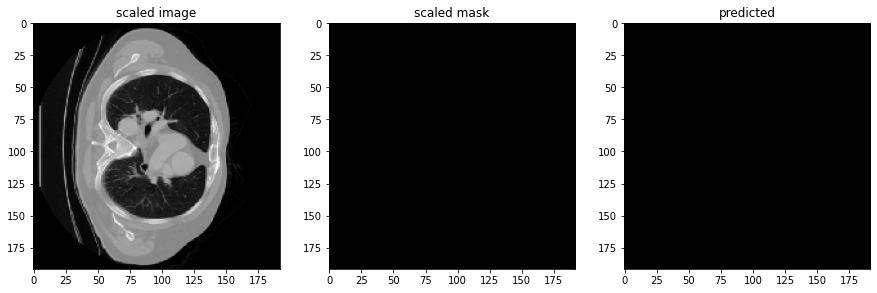

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]
Instance in test dataset:  96


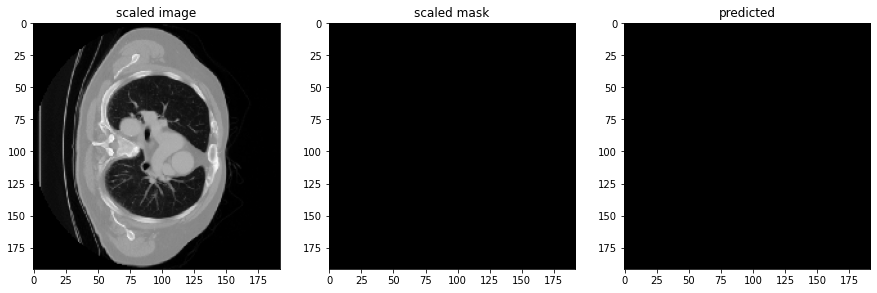

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]
Instance in test dataset:  97


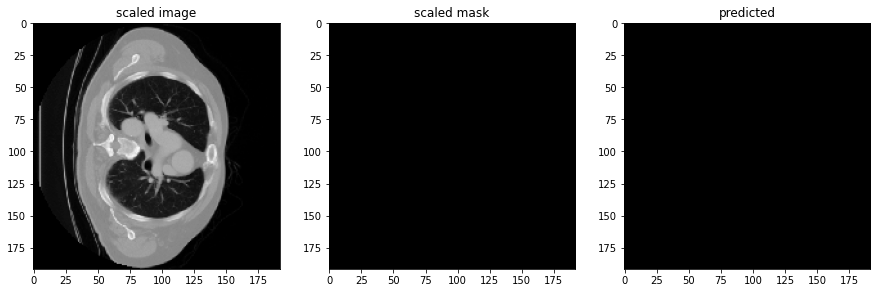

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]
Instance in test dataset:  98


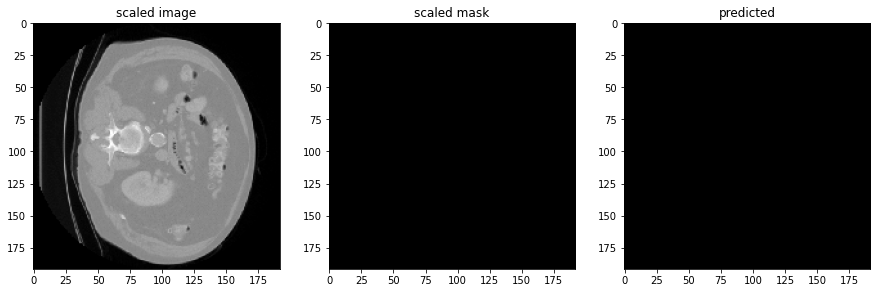

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]
Instance in test dataset:  99


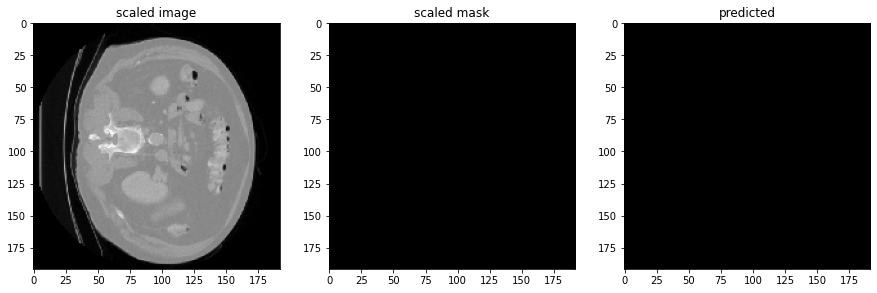

Scaled Mask Unique: [0]
Scaled Mask Unique: [0]


In [24]:
for i in range(0,100):
  print("Instance in test dataset: ", i)
  titles = ["scaled image", "scaled mask", "predicted"]
  display([np.expand_dims(scaled_test_images[i], axis=2), scaled_test_masks_no_encode[i], np.expand_dims(mask_pred_argmax[i], axis=2)], title_list=titles)
  print('Scaled Mask Unique:',np.unique(scaled_test_masks_no_encode[i]))
  print('Scaled Mask Unique:',np.unique(np.expand_dims(mask_pred_argmax[i], axis=2)))
  print("==================================================================================================================")

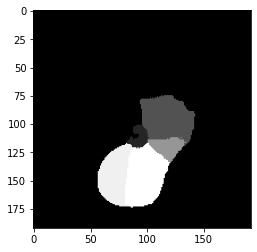

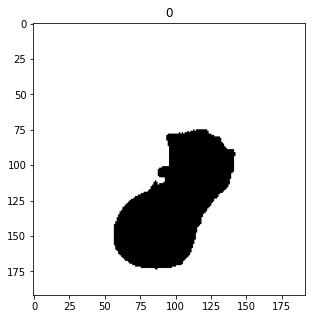

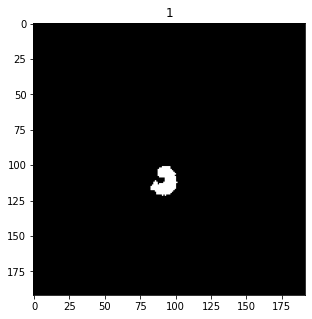

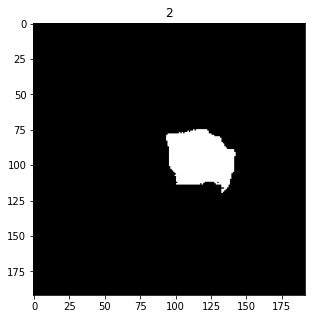

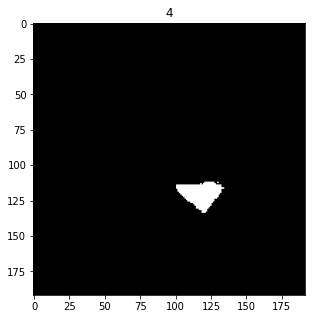

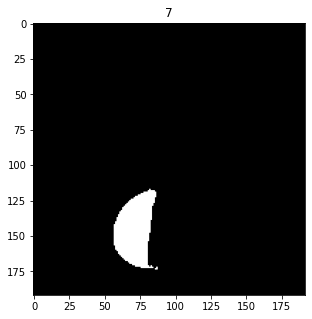

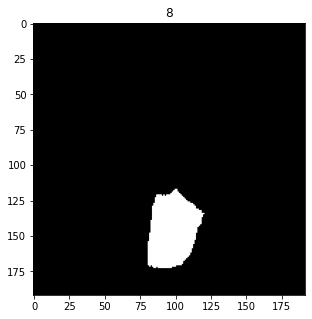

In [32]:
i = 29
plt.imshow(mask_pred_argmax[i], cmap='Greys_r')
for clss in np.unique(np.expand_dims(mask_pred_argmax[i], axis=2)):
  titles = []
  titles.append(str(clss))
  display([np.expand_dims(mask_pred_argmax[i] == clss, axis=2)], title_list=titles, figure_size=(5,5))

In [ ]:
# for i in range(0,50):
#   print("Instance in test dataset: ", i)
#   display([scaled_test_images[i], scaled_test_masks_no_encode[i], np.expand_dims(mask_pred_argmax[i], axis=2)])
#   mask_pred_argmaxOGSHAPE = cv2.resize(mask_pred_argmax[i].astype('float32')  , OG_IMG_SIZE, interpolation = cv2.INTER_LINEAR)
#   display([np.expand_dims(test_images[i], axis=2), test_masks_no_encode[i], np.expand_dims(mask_pred_argmaxOGSHAPE, axis=2)])
#   print("==================================================================================================================")

In [ ]:
tf.keras.backend.clear_session()
del imported_model